## Intro to Supervised Machine Learning

You work for a consultancy that specialized in real state: your clients involve developers, agencies and investors. A central aspect to the business is pricing. It's a domain of home appraisers, who aim to determine the value of a house in an unbiased way, and follow an official criteria to ensure they don't play in favour of neither the buyer or the seller.

However, the market often deviates from appraisal prices. Your consultancy wants to detect these deviations. It has acquired a dataset containing a historical register of housing prices - the actual prices at which the properties were sold. For each house, it also contains around 80 different features, such as the area, the state of the property, whether it has a backyard or not, etc.

You were tasked with creating a model that predicts the prices. Your manager told you that the model should have an average relative error of 15%. With such a model, you would be able to advise your clients on housing on a massively scalable way: once the features of a house have been collected, the model will output the price.


# Reading & Exploring

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv("/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/housing_prices.csv")

In [ ]:
# Get a glimpse of the dataframe
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.00,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.00,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.00,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.00,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.00,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.00,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.00,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.00,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.00,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.00,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.00,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.00,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.00,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.00,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.00,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
# Get the shape of the dataframe
data.shape

(1460, 81)

In [ ]:
# Get the colum types.
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

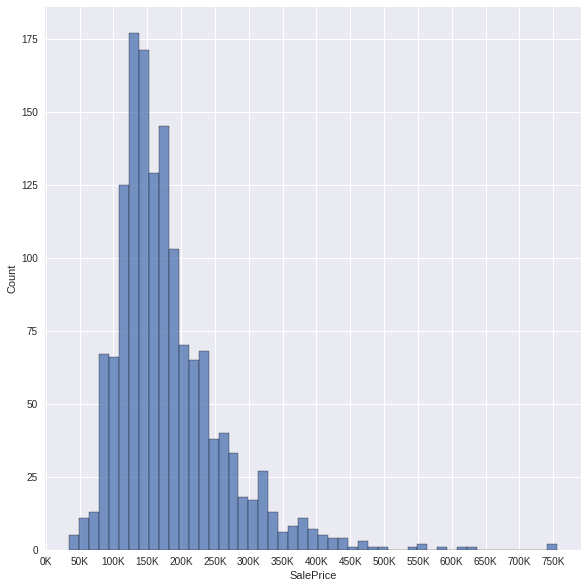

In [ ]:
# Get a histogram of selling prices which is what we want to predict
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.ticker as ticker
import seaborn as sns
%matplotlib inline

g = sns.displot(data['SalePrice'],height=8.27, aspect=1)
for ax in g.axes.flat:
    ax.xaxis.set_major_locator(ticker.MultipleLocator(50000))
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))


Clearly, tihs distribution is highly skewed, threrefore it's needs to be transformed. Dependent variables which are highly skewed can be easilly transformed taking the logarithm.

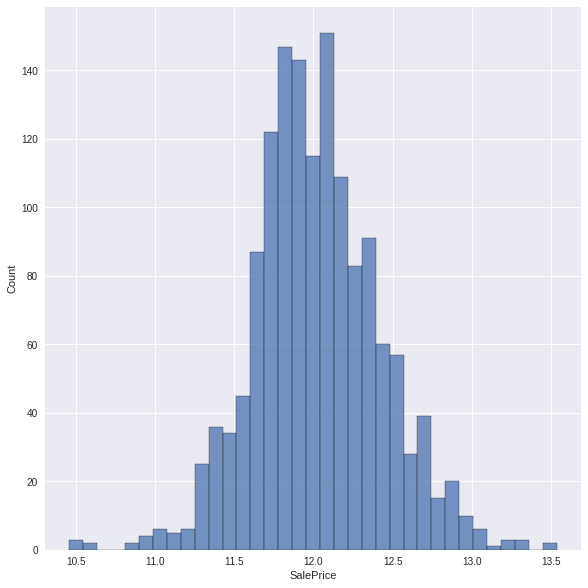

In [ ]:
g = sns.displot(np.log(data['SalePrice']),height=8.27, aspect=1)

In [ ]:
def plot_count_box(df, grouping_var, dependent_var, orient = 'v'):
    '''
    Function to plot two plots side by side.
    The left plot will be a count plot of 'grouping_var'
    The right plot will be a boxplot of 'dependent_var' grouped by 'grouping var'
    Inputs: 
    df = dataframe
    grouping_var = variable to perform the agregation
    dependent_var = variable to plot the boxplot
    Output:
    A canvas with a counplot on the left and boxplot on the right
    The boxplots are ordered based on the median value of the dependent feature.
    '''

    # Getting a list of unique valus for the grouping variable
    levels = list(df[grouping_var].unique())    
    diver = sns.color_palette("Paired", len(levels)) # RdBu, Set3, Paired
    # Setting a dictionary of {'value': color} to use in each plot
    cmap = dict(zip(levels,diver))

    mean_price = pd.DataFrame(df.groupby([grouping_var])[dependent_var].median().sort_values()).reset_index()

    fig, ax = plt.subplots(1,2,figsize=(16,8))
    if ( orient == 'v' ):
        sns.countplot(x = grouping_var, data = df, order = df[grouping_var].value_counts().index, ax = ax[0], palette = cmap) 
        sns.boxplot(y= dependent_var , x= grouping_var, data = data, order = mean_price[grouping_var], ax = ax[1], palette=  cmap)
        ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    else:
        sns.countplot(y = grouping_var, data = df, order = df[grouping_var].value_counts().index, ax = ax[0], palette = cmap)
        sns.boxplot(x= dependent_var , y= grouping_var, data = data, order = mean_price[grouping_var], ax = ax[1], palette = cmap)
        ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))        
    fig.show()
    pass

MSZoning: Identifies the general zoning classification of the sale.
		
       A	Agriculture
       C	Commercial
       FV	Floating Village Residential
       I	Industrial
       RH	Residential High Density
       RL	Residential Low Density
       RP	Residential Low Density Park 
       RM	Residential Medium Density

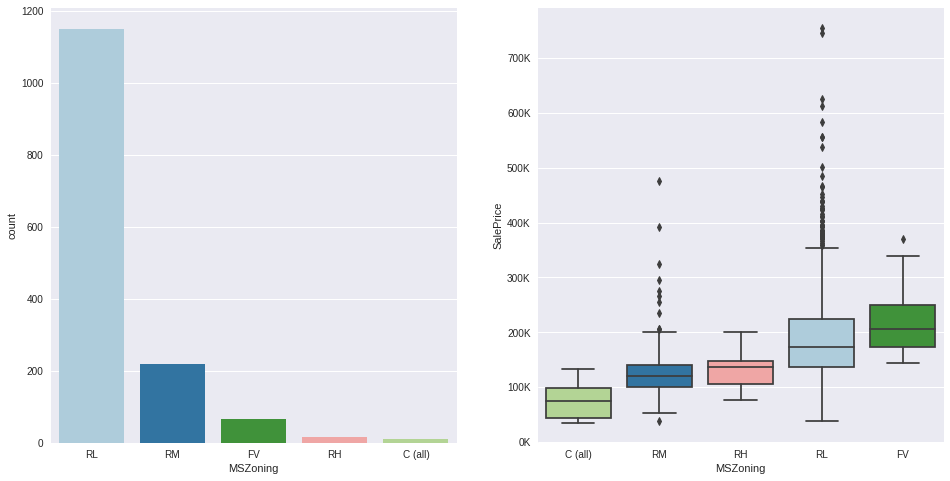

In [ ]:
# Check out the variable "MSZoning"

plot_count_box(data, 'MSZoning', 'SalePrice')

This is a higly imbalanced variable: we have much more samples of type RL than the othres. That prevents to make a fair comparison of the boxplots of selling prices split by this variable. In addition, even with the small size of the dataset there is clear overlap between the median SalesPrices for each value of MSZooning. Even more, the houses in the most sample MSZooning has has huge rangfe of values which doesn't allow to discriminate between the other values. Therefore, this variable doesn't look quite usefull to predit the SalesPrice.

In [ ]:
cols_to_drop = []
cols_to_drop += ['MSZoning']

Neighborhood: Physical locations within Ames city limits

       Blmngtn	Bloomington Heights
       Blueste	Bluestem
       BrDale	Briardale
       BrkSide	Brookside
       ClearCr	Clear Creek
       CollgCr	College Creek
       Crawfor	Crawford
       Edwards	Edwards
       Gilbert	Gilbert
       IDOTRR	Iowa DOT and Rail Road
       MeadowV	Meadow Village
       Mitchel	Mitchell
       Names	North Ames
       NoRidge	Northridge
       NPkVill	Northpark Villa
       NridgHt	Northridge Heights
       NWAmes	Northwest Ames
       OldTown	Old Town
       SWISU	South & West of Iowa State University
       Sawyer	Sawyer
       SawyerW	Sawyer West
       Somerst	Somerset
       StoneBr	Stone Brook
       Timber	Timberland
       Veenker	Veenker

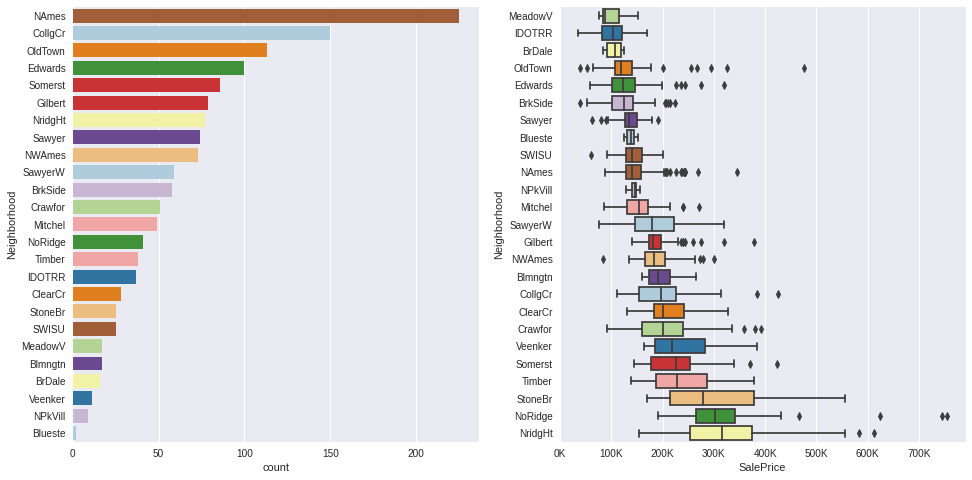

In [ ]:
# Check out the variable "Neighbourhood"

plot_count_box(data, 'Neighborhood', 'SalePrice', orient = 'h')

In [ ]:
len(list(data['Neighborhood'].unique()))

25

We have a similar problem as before. To make it worse, the `cardinality` (number of possible values) of this variable is huge (25) which makes a good candidate to group them in bigger groups. Therefore we can think in drop this variable.

In [ ]:
cols_to_drop += ['Neighborhood']

OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

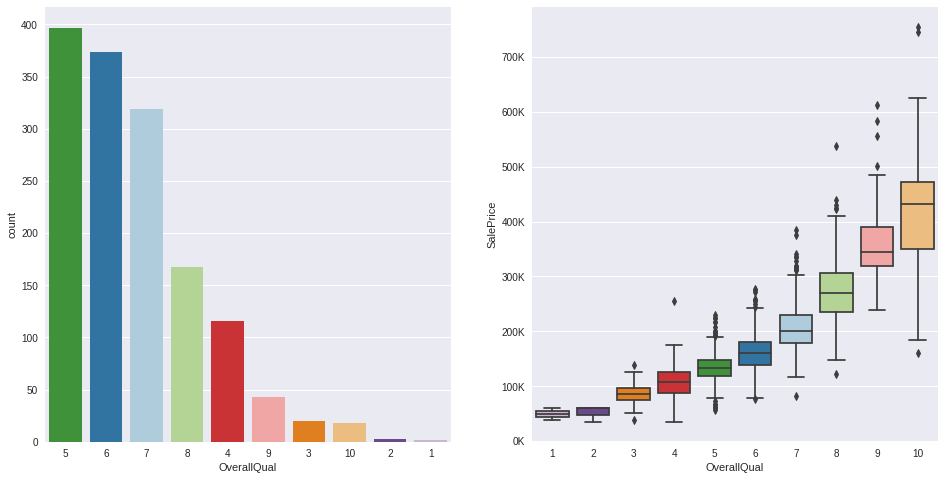

In [ ]:
# Check out the variable "OverallQual"

plot_count_box(data, 'OverallQual', 'SalePrice')

Again, we have a class imbalance. However, as it can be seen in the above picture the overal quality has a big impact on the SalePrice as it could be expected. This variable looks promising and the relationships between the OveralQual and the SalesPrice seems to be quadratic. Let's test this assumption

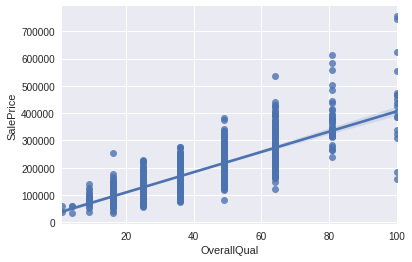

In [ ]:
sns.regplot(x = data['OverallQual']**2, y = data['SalePrice'])

We see vertical bars because this variable is a perfect example of an ordinal categorical variable.

OverallCond: Rates the overall condition of the house

       10   Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

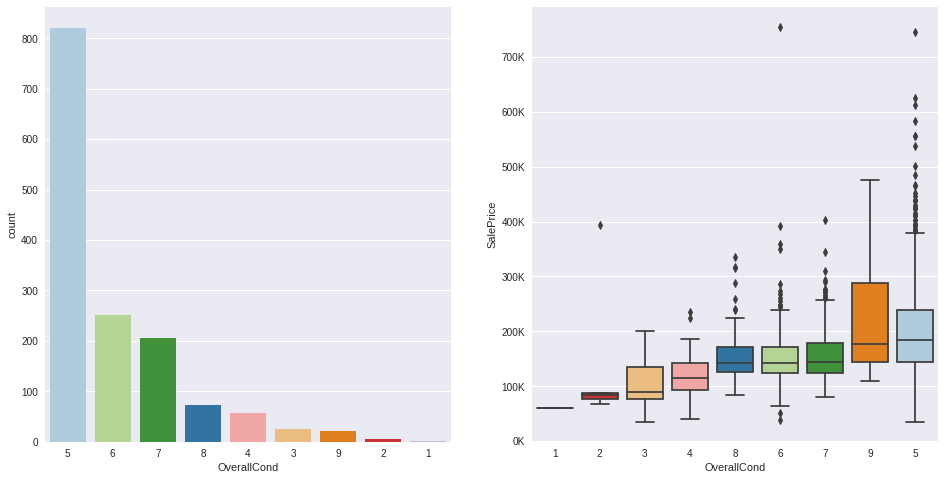

In [ ]:
# Check out the variable "OverallCond"

plot_count_box(data, "OverallCond", "SalePrice")

Again we also have a class imbalance and there is a high range of selling prices for every possible value of `OverallCond`. In addition, this variable can be redundant as we already have the previous one. Therefore, we will drop this one.

In [ ]:
cols_to_drop += ['OverallCond']

MoSold: Month Sold (MM)


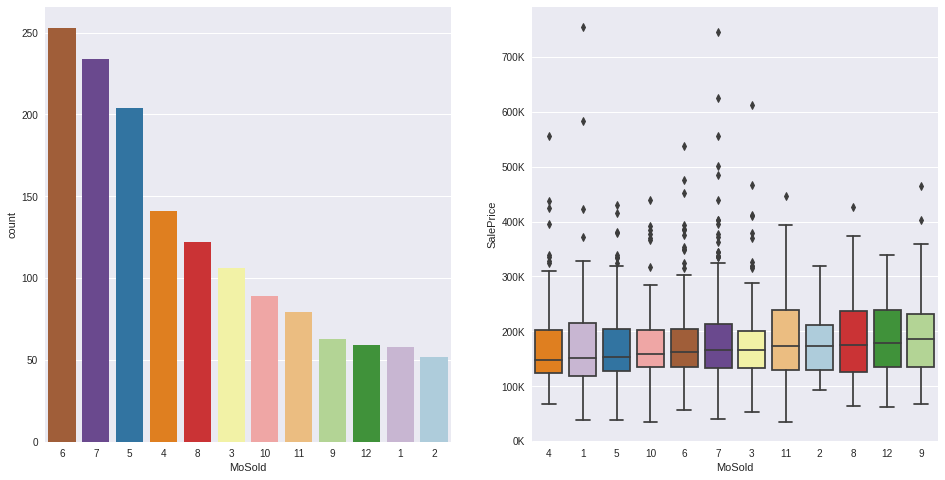

In [ ]:
# Check out the variable "MoSold"

plot_count_box(data, "MoSold", "SalePrice")

Selling month doesn't have any relationship with the selling price, even is worth of knowing that the month with the highest amount of sales is june. Therefore, let's drop the variable `MoSold`

In [ ]:
cols_to_drop += ['MoSold']

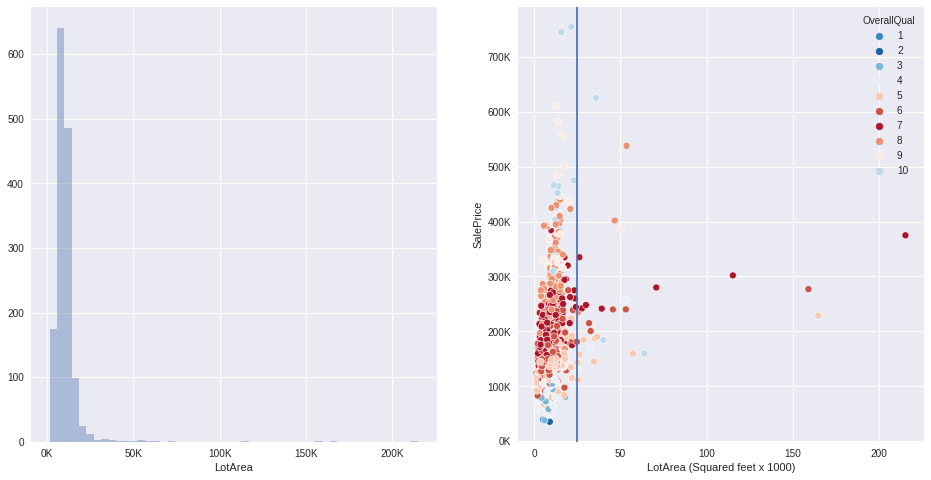

In [ ]:
# Check out the variable "LotArea"which is continuous

levels = list(data['OverallQual'].unique())  # OverallCond  
diver = sns.color_palette("RdBu", len(levels)) # RdBu, Set3, Paired
# Setting a dictionary of {'value': color} to use in each plot
cmap = dict(zip(levels,diver))

fig, ax = plt.subplots(1,2,figsize=(16,8))
sns.distplot(data['LotArea'], ax = ax[0], kde=False)
sns.scatterplot(x = 'LotArea', y = 'SalePrice', data = data, ax = ax[1], hue ='OverallQual', palette=cmap) # hue ='OverallCond'
ax[0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
ax[1].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}'))
ax[1].set_xlabel('LotArea (Squared feet x 1000)')
ax[1].axvline(x=25000)



Clearly, the distribution of squared feet is strongly skewed. On the other hamd it seems that below 25K the relationship between the selling price and the squared feet seems to be linnear. In contrast, for higher surface values, the is no clear relationship between the selling price and the surface.

Another conclussion that can be extracted from the previous plots is that above 25K squared feets, the overall quality is usually above 5.

Let's check the previous assumption

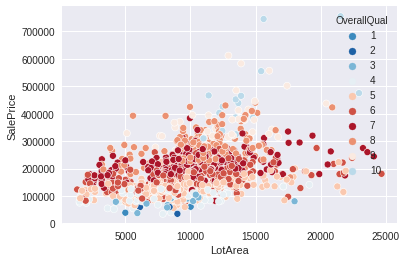

In [ ]:
sns.scatterplot(x ='LotArea', y = 'SalePrice', data = data[data['LotArea'] < 25000], hue ='OverallQual', palette=cmap)

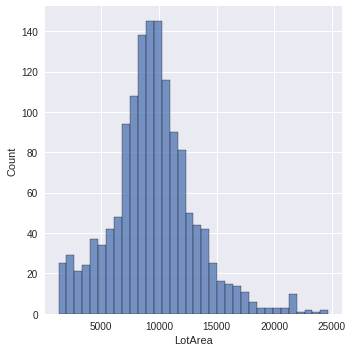

In [ ]:
sns.displot(data[data['LotArea'] < 25000 ]['LotArea'], kde=False)

We can apply this filter to our dataframe

In [ ]:
data = data[data['LotArea'] < 25000 ]

# Finding missing values

In [ ]:
# Get a dataframe of missing values by column. Use sort_values(ascending=False) to sort the results
nulls = pd.DataFrame(data.isnull().sum().sort_values(ascending=False))


# Use reset_index() to make the index to become column and rename the column names
nulls.reset_index(inplace=True)
nulls.columns = ['Variable','Count']
nulls.head()

,Variable,Count
0,PoolQC,1423
1,MiscFeature,1376
2,Alley,1337
3,Fence,1148
4,FireplaceQu,683


In [ ]:
# Get the columns which have NA's

nulls[nulls['Count'] > 0].Variable

0           PoolQC
1      MiscFeature
2            Alley
3            Fence
4      FireplaceQu
5      LotFrontage
6       GarageCond
7       GarageType
8      GarageYrBlt
9     GarageFinish
10      GarageQual
11    BsmtExposure
12    BsmtFinType2
13    BsmtFinType1
14        BsmtCond
15        BsmtQual
16      MasVnrArea
17      MasVnrType
18      Electrical
Name: Variable, dtype: object

Let's start dealing with those NA's column by column

PoolQC: Pool quality
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       NA	No Pool

If the is no pool, we can assing a value flag to it like 'NA'

In [ ]:
data['PoolQC'] = data['PoolQC'].fillna('NA')
data['PoolQC'].unique()

array(['NA', 'Fa', 'Gd', 'Ex'], dtype=object)

Now let's inspect the relatioship between `PoolQC`and `SellPrice`



In [ ]:
data['PoolQC'].value_counts()

NA    1423
Gd       2
Fa       2
Ex       1
Name: PoolQC, dtype: int64

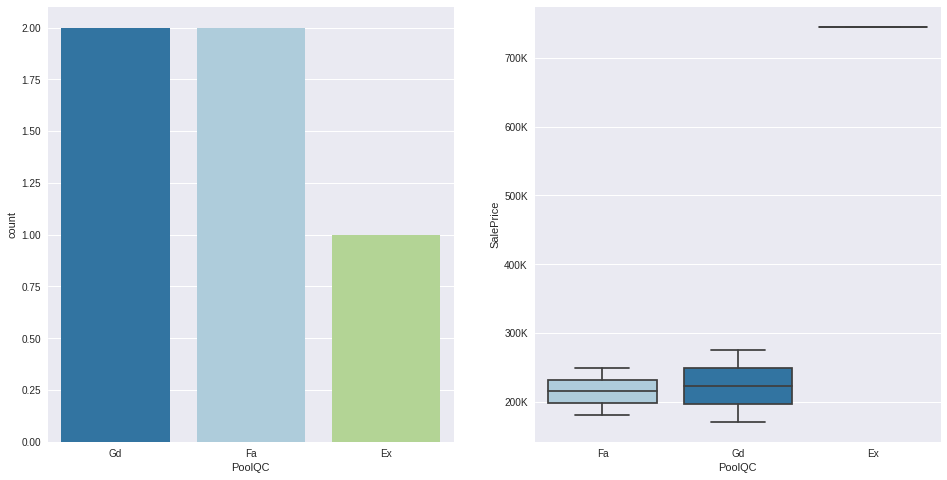

In [ ]:
plot_count_box(data[data['PoolQC'] != 'NA'], "PoolQC", "SalePrice")

Clearly, the sampling of houses with pool is not big enough to extract conclussions. Therefore we can drop this feature

In [ ]:
cols_to_drop += ['PoolQC']

MiscFeature: Miscellaneous feature not covered in other categories
		
       Elev	Elevator
       Gar2	2nd Garage (if not described in garage section)
       Othr	Other
       Shed	Shed (over 100 SF)
       TenC	Tennis Court
       NA	None

In [ ]:
data['MiscFeature'].value_counts()

Shed    47
Gar2     2
Othr     2
TenC     1
Name: MiscFeature, dtype: int64

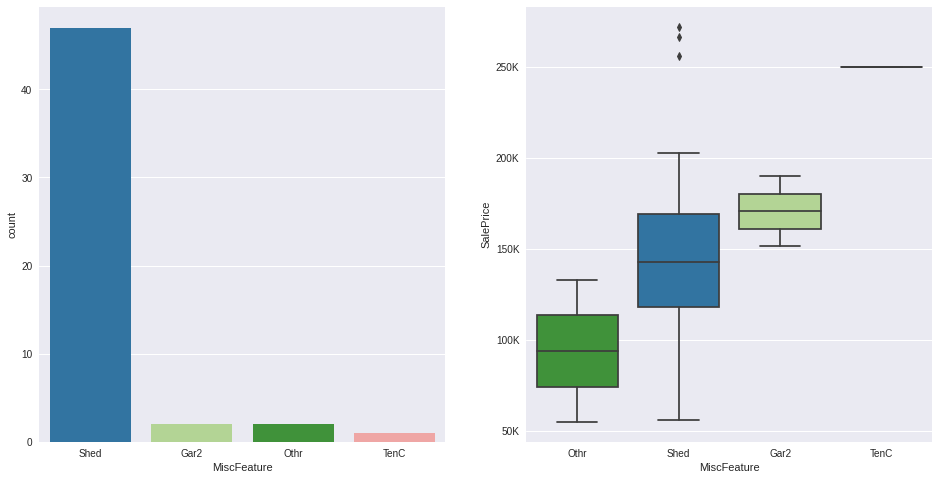

In [ ]:
plot_count_box(data, "MiscFeature", "SalePrice")

Clearly we don't have enough samples to extract conclussions. Therefore, we will drop this other feature.

In [ ]:
cols_to_drop += ['MiscFeature']

Alley: Type of alley access to property

       Grvl	Gravel
       Pave	Paved
       NA 	No alley access

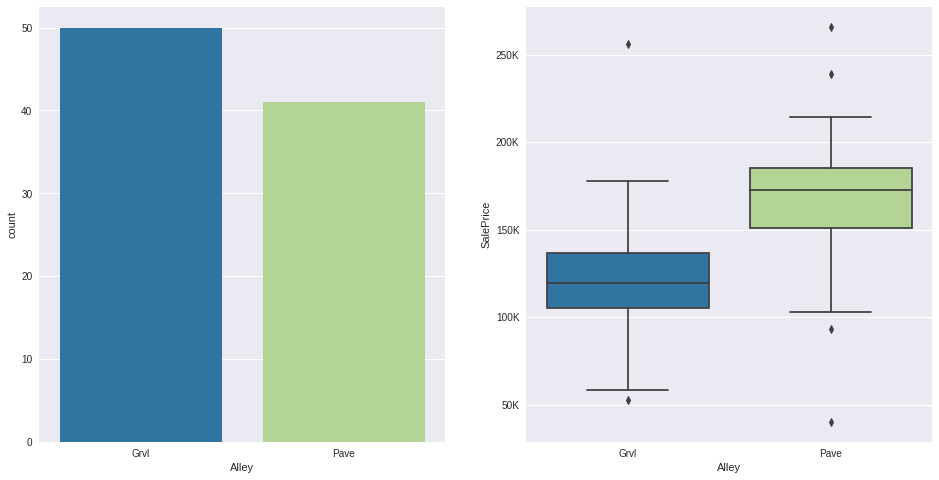

In [ ]:
plot_count_box(data, "Alley", "SalePrice")

It seems to be some overlap between both possibilities although having a pavement alley usually has a bigger impact and the sampling is poor. Again we will drop this feature.

In [ ]:
cols_to_drop += ['Alley']

Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence

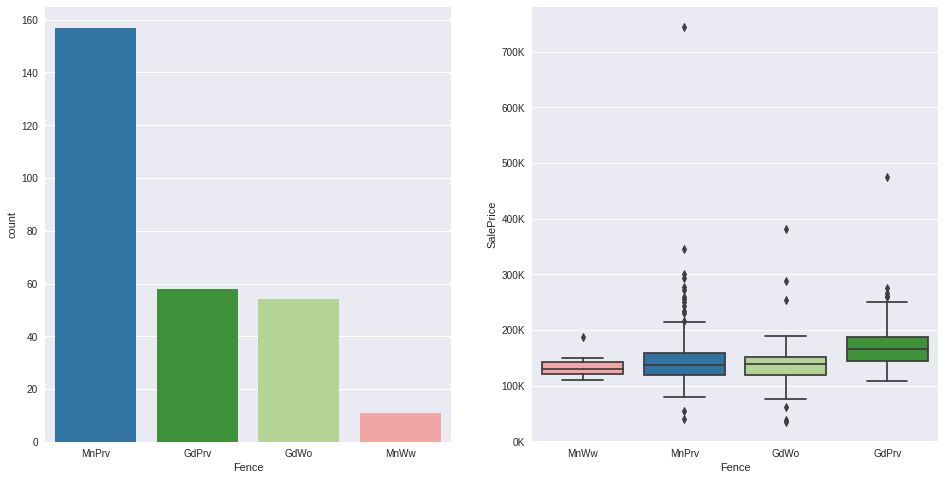

In [ ]:
plot_count_box(data, "Fence", "SalePrice")

Clearly it looks like that there are no significant differences among the fence condition. Therefore this variable is a good candidate to drop.

In [ ]:
cols_to_drop += ['Fence']

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [ ]:
data['FireplaceQu'] = data['FireplaceQu'].fillna('NA')

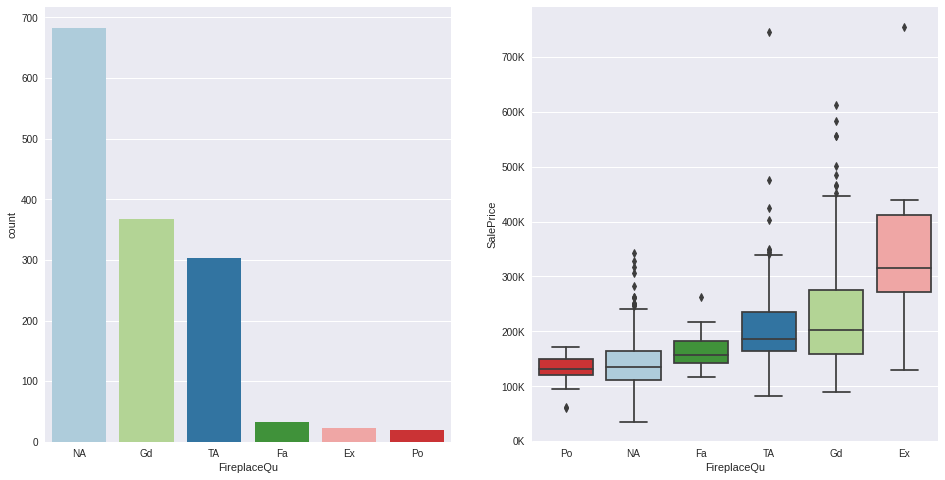

In [ ]:
plot_count_box(data, "FireplaceQu", "SalePrice")

In [ ]:
data['FireplaceQu'].value_counts()

NA    683
Gd    367
TA    303
Fa     32
Ex     23
Po     20
Name: FireplaceQu, dtype: int64

Clearly, the fireplace condition ( when it's present ) can have an impact. Let's test this. 

In [ ]:
print("Mean price of houses with fireplace: ",round(data[data['FireplaceQu'] != 'NA']['SalePrice'].mean()))
print("Mean price od houses without fireplace: ",round(data[data['FireplaceQu'] == 'NA']['SalePrice'].mean()))
y = data[data['FireplaceQu'] != 'NA']['SalePrice'].mean()
n = data[data['FireplaceQu'] == 'NA']['SalePrice'].mean()
print("Average price increase by having a fireplace: {} %".format(round(((y/n)-1)*100)))

Mean price of houses with fireplace:  214440
Mean price od houses without fireplace:  141220
Average price increase by having a fireplace: 52 %


Therefore, let's make this feature binnary.

In [ ]:
data.rename(columns={'FireplaceQu': 'Fireplace'}, inplace = True)
data['Fireplace'] = np.where(data['Fireplace'].isin(['Gd','TA','Fa','Ex','Po']),1,0)

LotFrontage: Linear feet of street connected to property

,LotFrontage,SalePrice
LotFrontage,1.00,0.39
SalePrice,0.39,1.00


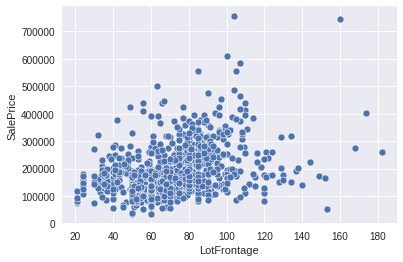

In [ ]:
sns.scatterplot(x = 'LotFrontage',y = 'SalePrice', data = data)
data[['LotFrontage','SalePrice']].corr()

There is no clear linear relationship between both features. Therefore, we will drop the feature.

In [ ]:
cols_to_drop += ["LotFrontage"]

6. GarageCond
7. GarageType
8. GarageYrBlt
9. GarageFinish
10. GarageQual

All those variables seem redundant on a first look. Let's inspect them and pick the best.

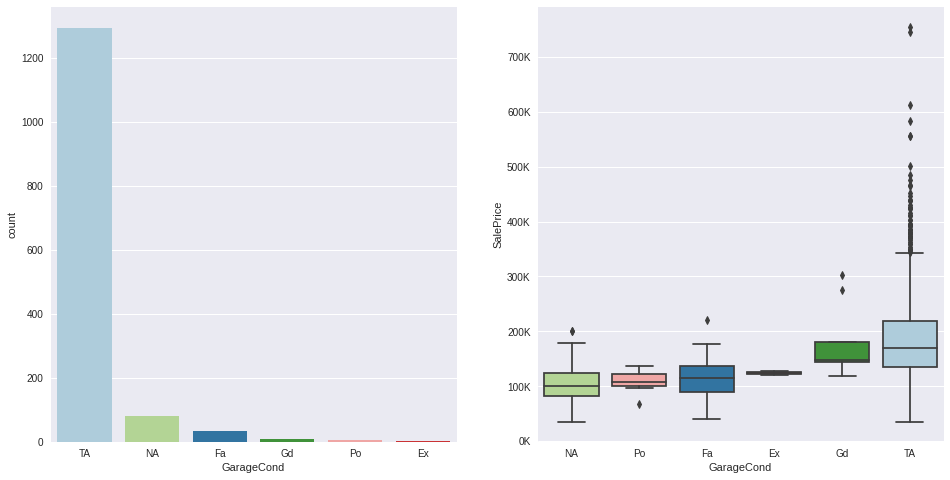

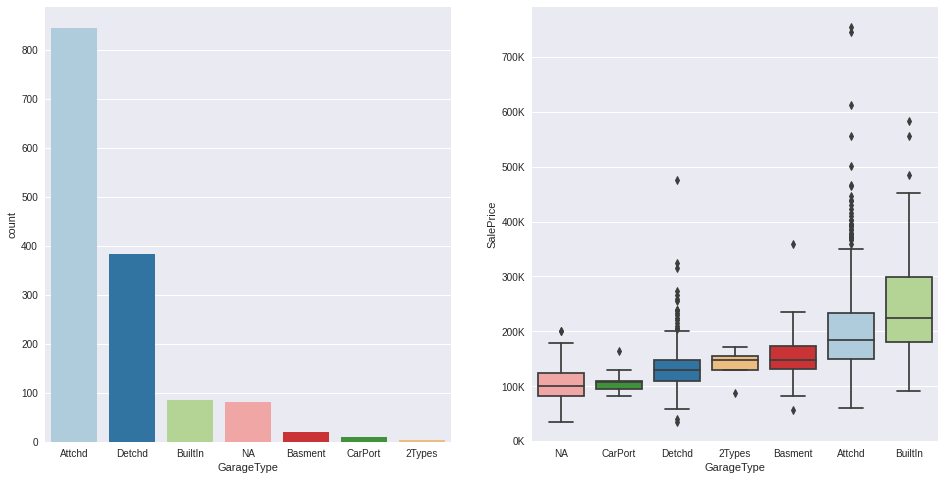

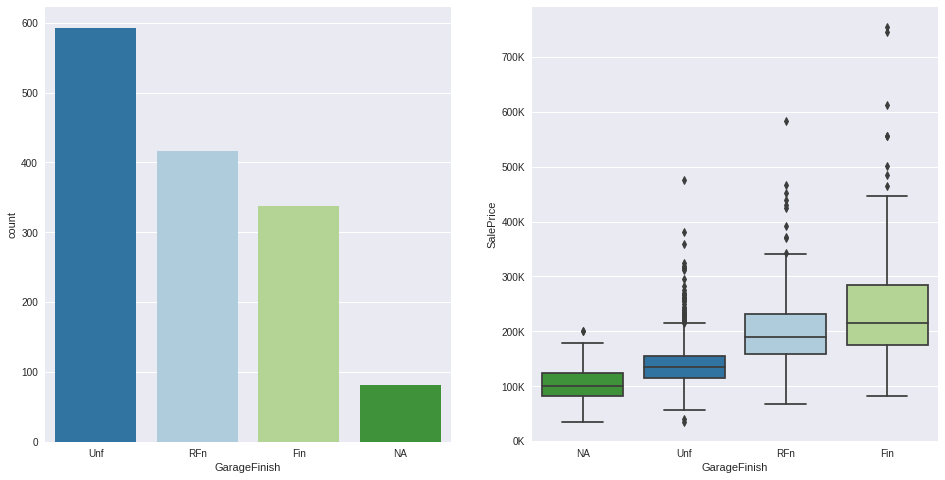

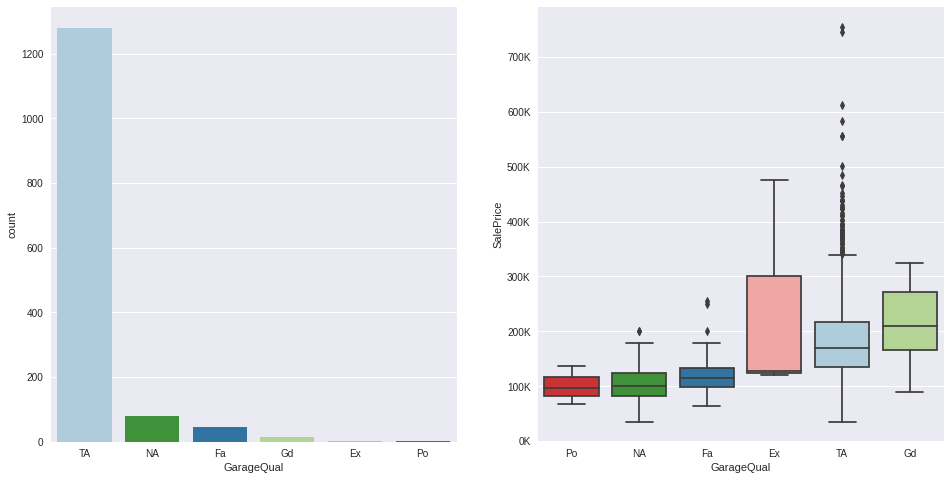

In [ ]:
my_list = ['GarageCond','GarageType','GarageFinish','GarageQual']

for elem in my_list:
    data[elem] = data[elem].fillna('NA')
    plot_count_box(data, elem, "SalePrice")

`GarageCond` is heavily unbalanced and thre is high overlap between the boxplots for all the values. We can drop this feature.

`GarageType` is heavyly unbalanced which makes the statistics poor and there is too much overlap between the types to extract conclussions. We can drop this feature.

`GarageFinish` has enough samples of each type but there is significant overlap between the boxplots, even though it seems to increase slightly the selling price.

`GarageQual` is also heavily unbalanced and seems to be quite similar to be redundant. We can think of dropping it.

It looks like having a garage impact but those characteristics seem unclear.

In [ ]:
cols_to_drop += ['GarageCond','GarageType','GarageQual']

Let's inspect `GarageYrBlt`


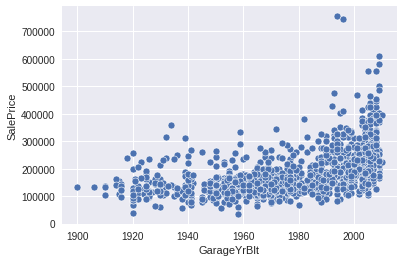

In [ ]:
sns.scatterplot(x = 'GarageYrBlt', y = 'SalePrice', data = data)

It looks like that the Sale Price increases over time, although not linearly. It would be more interesting to know in which year the dataset was collected in order to know how much lasted since the last renewal. It looks more reasonable to compute the difference in terms of mean price between those house which have a garage and don't. Hoewever, a house can have a garage but a missing value in this field. This will bias conclussions.

In [ ]:
y = data[data['GarageYrBlt'].isna() == True]['SalePrice'].mean()
n = data[data['GarageYrBlt'].isna() == False]['SalePrice'].mean()
print("Mean price of houses with garage: ",round(y))
print("Mean price od houses without garave: ",round(n))

print("Average price increase by having a garage: {} %".format(round(((y/n)-1)*100)))

Mean price of houses with garage:  103317
Mean price od houses without garave:  183996
Average price increase by having a garage: -44 %


In [ ]:
cols_to_drop += ['GarageYrBlt']

11. BsmtExposure
12. BsmtFinType2
13. BsmtFinType1
14. BsmtCond
15. BsmtQual

BsmtQual: Evaluates the height of the basement

* Ex	Excellent (100+ inches)	
* Gd	Good (90-99 inches)
* TA	Typical (80-89 inches)
* Fa	Fair (70-79 inches)
* Po	Poor (<70 inches)
* NA	No Basemen

BsmtCond: Evaluates the general condition of the basement

* Ex	Excellent
* Gd	Good
* TA	Typical - slight dampness allowed
* Fa	Fair - dampness or some cracking or settling
* Po	Poor - Severe cracking, settling, or wetness
* NA	No Basement

BsmtExposure: Refers to walkout or garden level walls

* Gd	Good Exposure
* Av	Average Exposure (split levels or foyers typically score average or above)	
* Mn	Mimimum Exposure
* No	No Exposure
* NA	No Basement

BsmtFinType1: Rating of basement finished area

* GLQ	Good Living Quarters
* ALQ	Average Living Quarters
* BLQ	Below Average Living Quarters	
* Rec	Average Rec Room
* LwQ	Low Quality
* Unf	Unfinshed
* NA	No Basement

BsmtFinSF1: Type 1 finished square feet

BsmtFinType2: Rating of basement finished area (if multiple types)

* GLQ	Good Living Quarters
* ALQ	Average Living Quarters
* BLQ	Below Average Living Quarters	
* Rec	Average Rec Room
* LwQ	Low Quality
* Unf	Unfinshed
* NA	No Basement

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

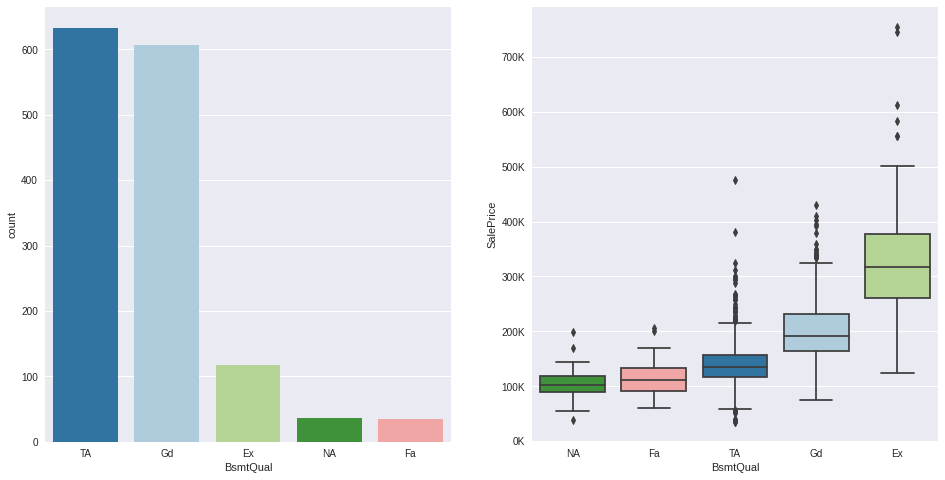

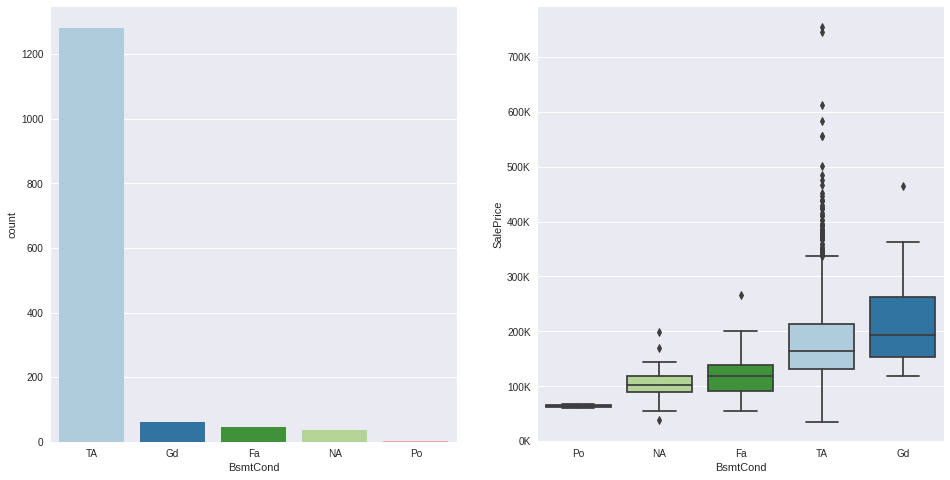

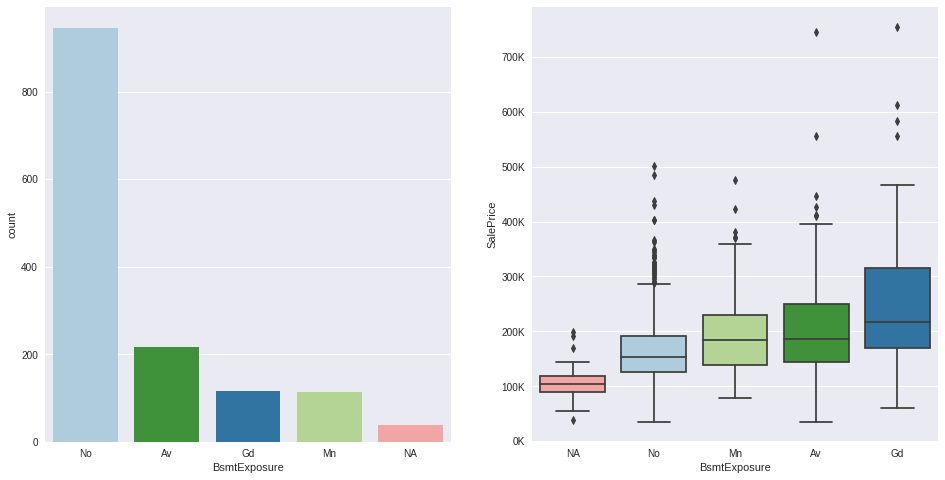

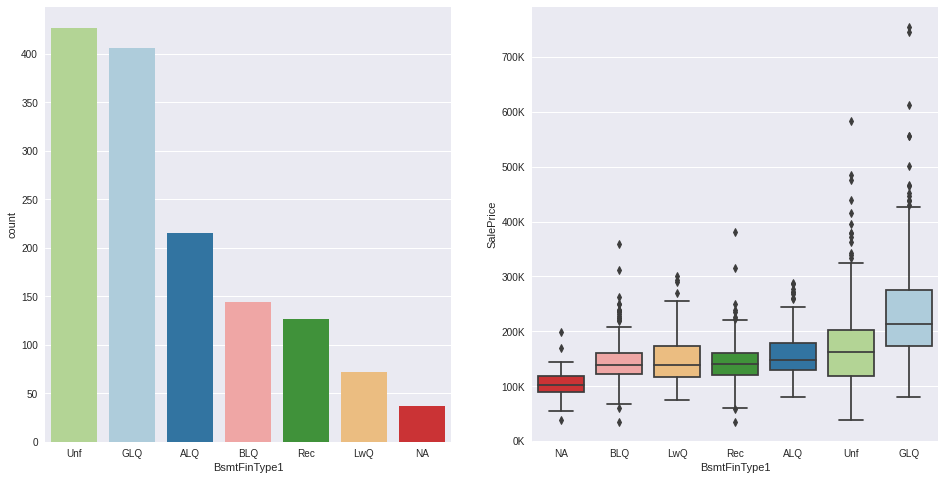

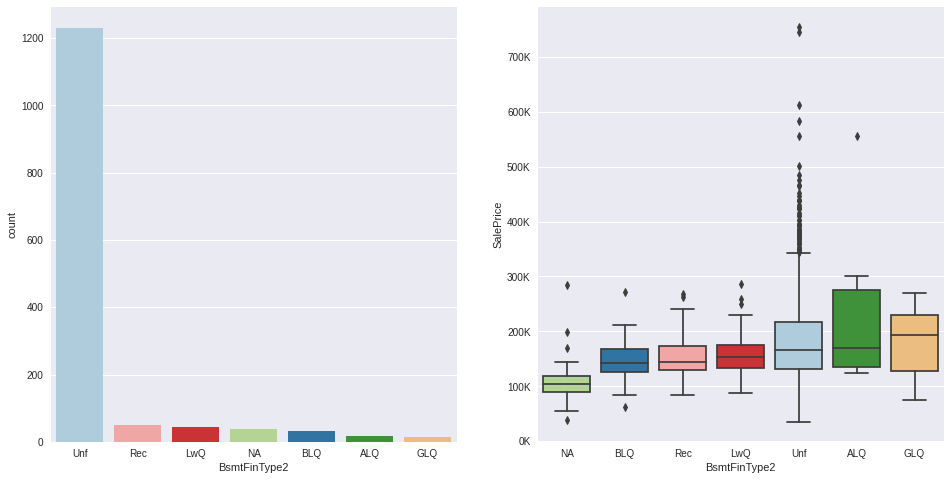

In [ ]:
my_list = ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

for elem in my_list:
    data[elem] = data[elem].fillna('NA')
    plot_count_box(data, elem, "SalePrice")

`BsmtQual` is heavily imbalanced. The biggest groups have a big overlap, therefore those groups can be groupped together in a single group.

`BsmCons`is also heavily unbalanced to extract conclussions.

`BsmtExposure` values have a big overlap.

`BsmtFinType1` and `BsmtFinType2` have too much overlap between the possible values. In particular, for the last value there is a high class imbalance.

All those features have high overlap, therefore they are not informative. Let's drop them.

In [ ]:
cols_to_drop += ['BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2']

BsmtFinSF2: Type 2 finished square feet

BsmtUnfSF: Unfinished square feet of basement area

TotalBsmtSF: Total square feet of basement area

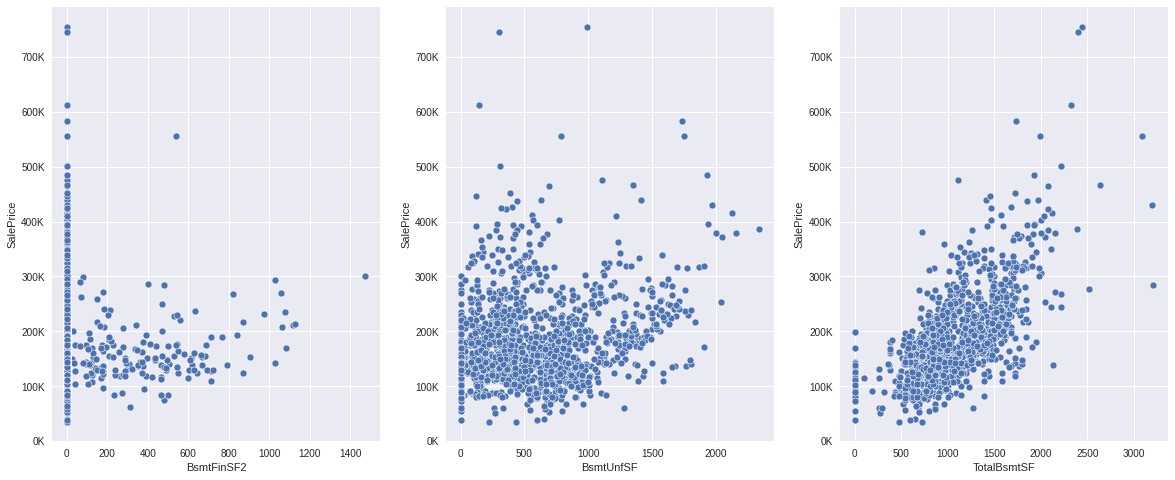

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,8))
sns.scatterplot(x= 'BsmtFinSF2' , y= 'SalePrice', data = data,  ax = ax[0])
sns.scatterplot(x= 'BsmtUnfSF' , y= 'SalePrice', data = data,  ax = ax[1])
sns.scatterplot(x= 'TotalBsmtSF', y= 'SalePrice', data = data,  ax = ax[2])
ax[0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
ax[1].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
ax[2].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))

According to the previous figure, it only seems to be a relationship between `TotalBsmtSF` and `SalePrice`.

In [ ]:
cols_to_drop += ['BsmtFinSF2','BsmtUnfSF']

In [ ]:
data['TotalBsmtSF'] = data['TotalBsmtSF'].fillna(0) 
data[['TotalBsmtSF','SalePrice']].corr()

,TotalBsmtSF,SalePrice
TotalBsmtSF,1.00,0.65
SalePrice,0.65,1.00


MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
	
MasVnrArea: Masonry veneer area in square feet

In [ ]:
data['MasVnrType'].value_counts(dropna=False)
data['MasVnrType'] = data['MasVnrType'].fillna('None')

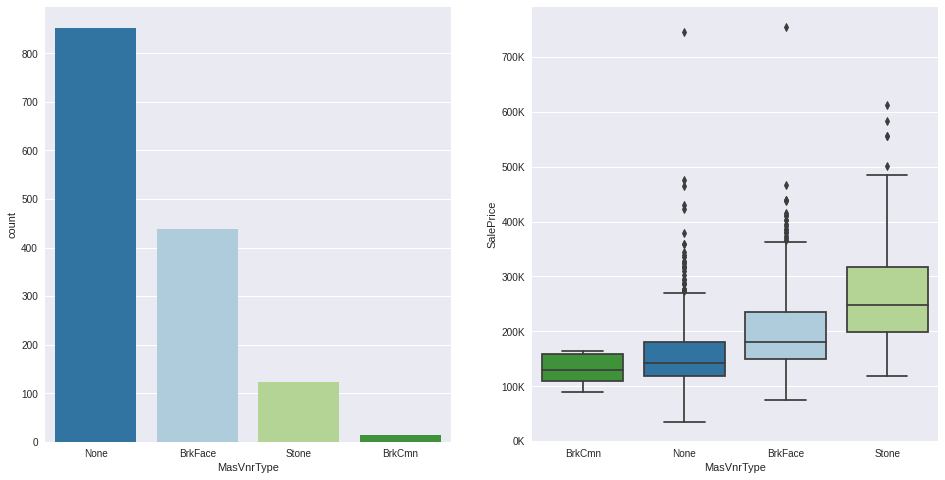

In [ ]:
# MasVnrType

plot_count_box(data, 'MasVnrType', "SalePrice")

Too much overlap and imbalance and overlap. Let's drop this feature.

In [ ]:
cols_to_drop += ['MasVnrType']

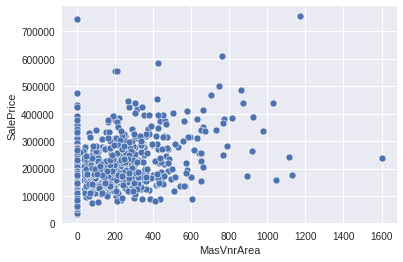

In [ ]:
# MasVnrArea

sns.scatterplot( x = 'MasVnrArea', y = 'SalePrice', data = data)

Not relation at all. Another feature to drop.

In [ ]:
cols_to_drop += ['MasVnrArea']

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

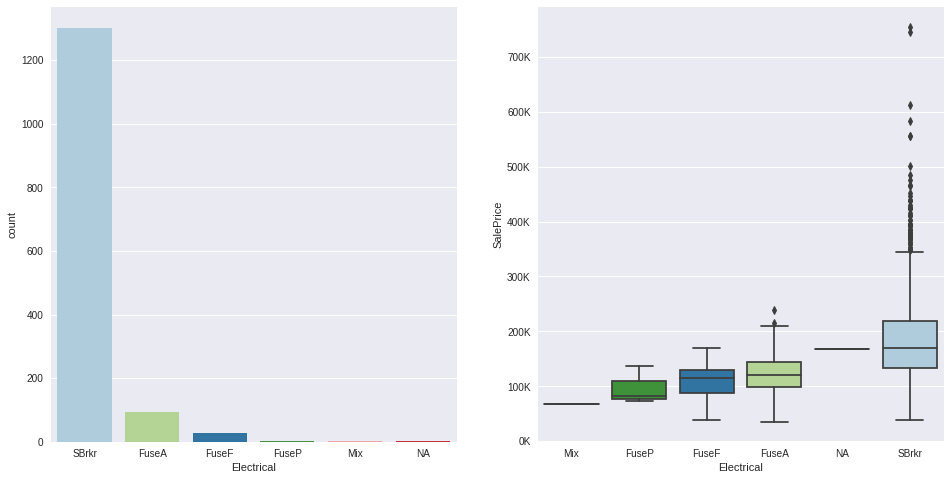

In [ ]:
data['Electrical'] = data['Electrical'].fillna('NA') 

plot_count_box(data, 'Electrical', "SalePrice")

Another example of a feature with high class imbalance and high overlap between the boxplots.

In [ ]:
cols_to_drop += ['Electrical']

In [ ]:
cols_to_drop

['MSZoning',
 'Neighborhood',
 'OverallCond',
 'MoSold',
 'PoolQC',
 'MiscFeature',
 'Alley',
 'Fence',
 'LotFrontage',
 'GarageCond',
 'GarageType',
 'GarageQual',
 'GarageYrBlt',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'MasVnrType',
 'MasVnrArea',
 'Electrical']

# Dropping unwanted columns

In [ ]:
data.drop(columns = cols_to_drop, axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 0 to 1459
Data columns (total 58 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Id             1428 non-null   int64 
 1   MSSubClass     1428 non-null   int64 
 2   LotArea        1428 non-null   int64 
 3   Street         1428 non-null   object
 4   LotShape       1428 non-null   object
 5   LandContour    1428 non-null   object
 6   Utilities      1428 non-null   object
 7   LotConfig      1428 non-null   object
 8   LandSlope      1428 non-null   object
 9   Condition1     1428 non-null   object
 10  Condition2     1428 non-null   object
 11  BldgType       1428 non-null   object
 12  HouseStyle     1428 non-null   object
 13  OverallQual    1428 non-null   int64 
 14  YearBuilt      1428 non-null   int64 
 15  YearRemodAdd   1428 non-null   int64 
 16  RoofStyle      1428 non-null   object
 17  RoofMatl       1428 non-null   object
 18  Exterior1st    1428 non-null

In [ ]:
data.shape

(1428, 58)

# Inspecting categorical features

'Street'

In [ ]:
data['Street'].value_counts()

Pave    1424
Grvl       4
Name: Street, dtype: int64

High class imbalance, let's drop it.

In [ ]:
cols_to_drop = ['Street']

LotShape: General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

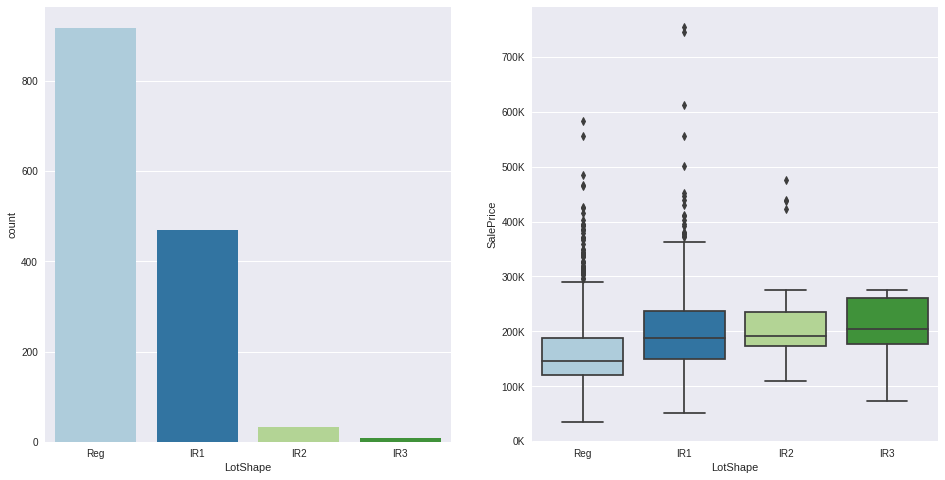

In [ ]:
plot_count_box(data, 'LotShape', 'SalePrice')

It doesn't seem to have a impact on the sale price. Let's drop it.

In [ ]:
cols_to_drop += ['LotShape']

LandContour: Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression

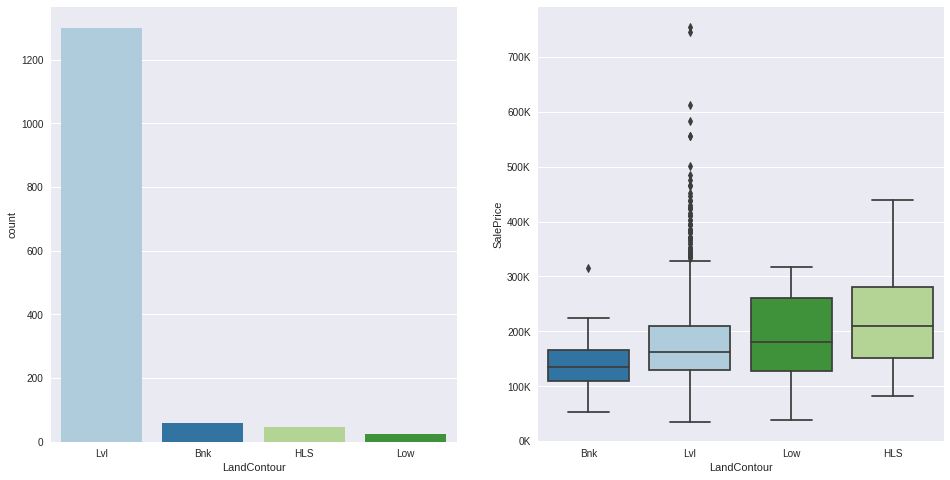

In [ ]:
plot_count_box(data, 'LandContour', 'SalePrice')

No clear differences and high class imbalance within the possible values. Another feature to drop.

In [ ]:
cols_to_drop += ['LandContour']

Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

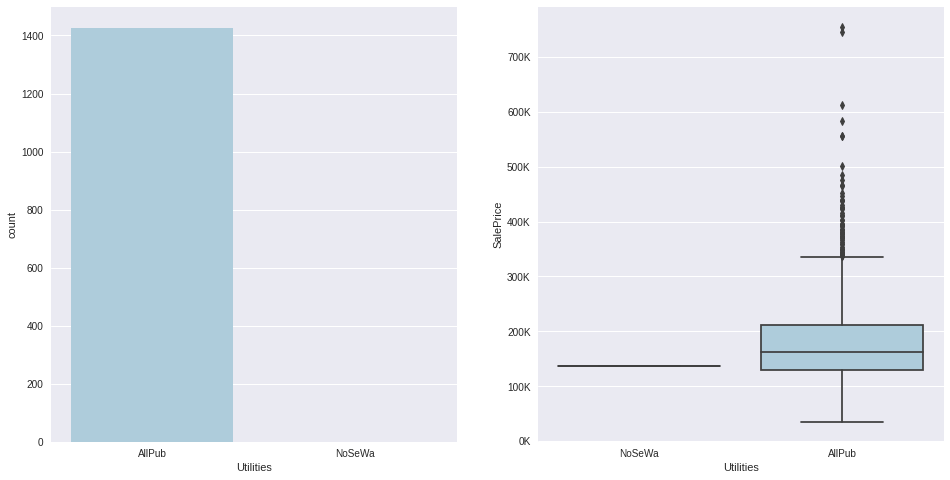

In [ ]:
plot_count_box(data, 'Utilities', 'SalePrice')

Huge class imbalance, therefore this feature is not informative.

In [ ]:
cols_to_drop += ['Utilities']

LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

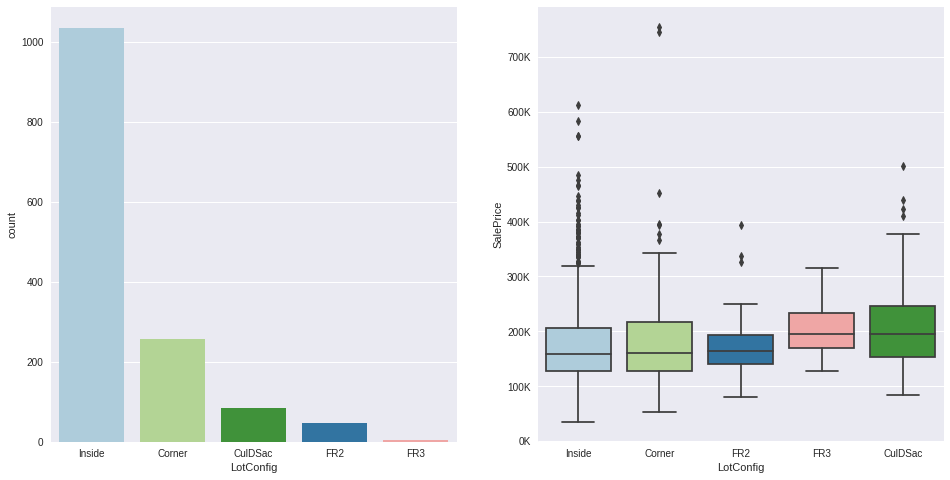

In [ ]:
plot_count_box(data, 'LotConfig', 'SalePrice')

High class imbalance and not informative.

In [ ]:
cols_to_drop += ['LotConfig']

LandSlope: Slope of property
		
       Gtl	Gentle slope
       Mod	Moderate Slope	
       Sev	Severe Slope

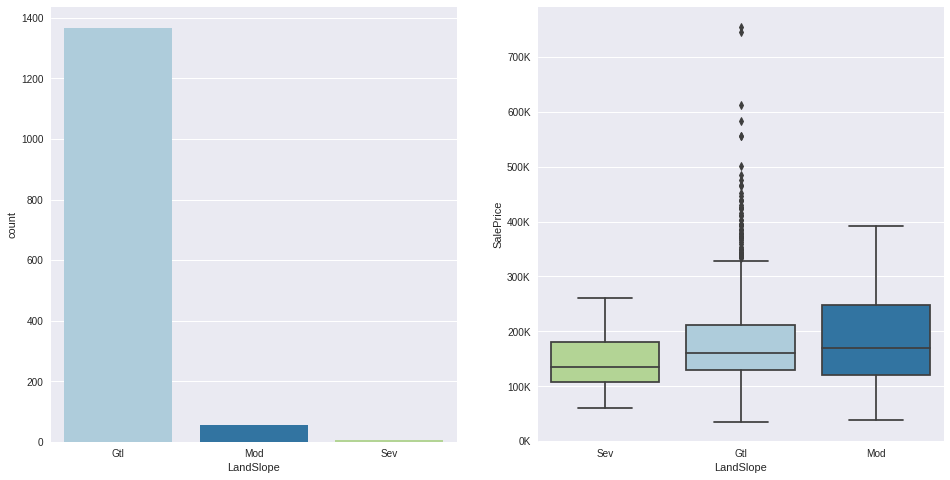

In [ ]:
plot_count_box(data, 'LandSlope', 'SalePrice')

Same as well

In [ ]:
cols_to_drop += ['LandSlope']

Condition1: Proximity to various conditions
	
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

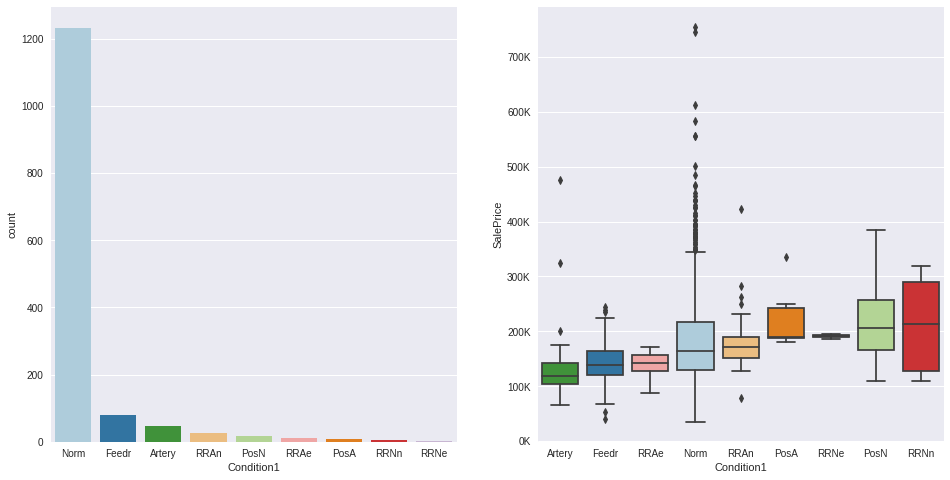

In [ ]:
plot_count_box(data, 'Condition1', 'SalePrice')

Small statistics to extract conclussions. Let's drop it.

In [ ]:
cols_to_drop += ['Condition1']

Condition2: Proximity to various conditions (if more than one is present)
		
       Artery	Adjacent to arterial street
       Feedr	Adjacent to feeder street	
       Norm	Normal	
       RRNn	Within 200' of North-South Railroad
       RRAn	Adjacent to North-South Railroad
       PosN	Near positive off-site feature--park, greenbelt, etc.
       PosA	Adjacent to postive off-site feature
       RRNe	Within 200' of East-West Railroad
       RRAe	Adjacent to East-West Railroad

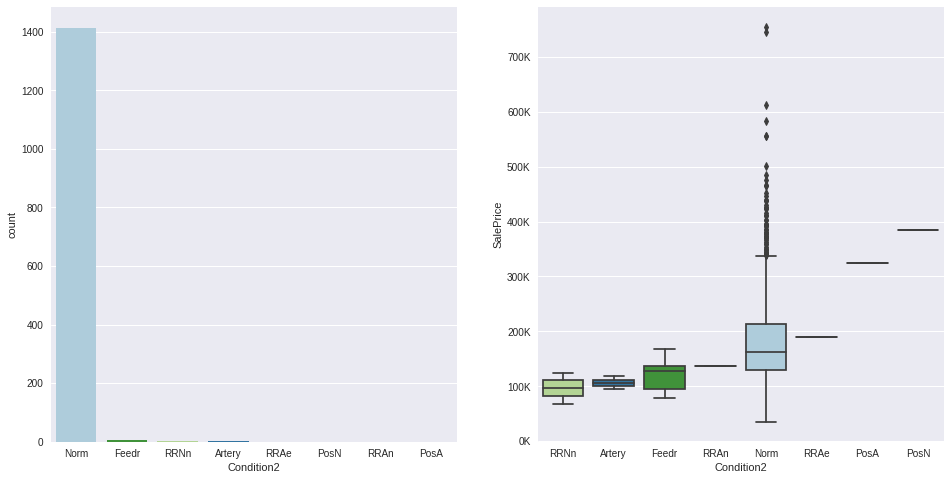

In [ ]:
plot_count_box(data, 'Condition2', 'SalePrice')

Even worse.

In [ ]:
cols_to_drop += ['Condition2']

BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

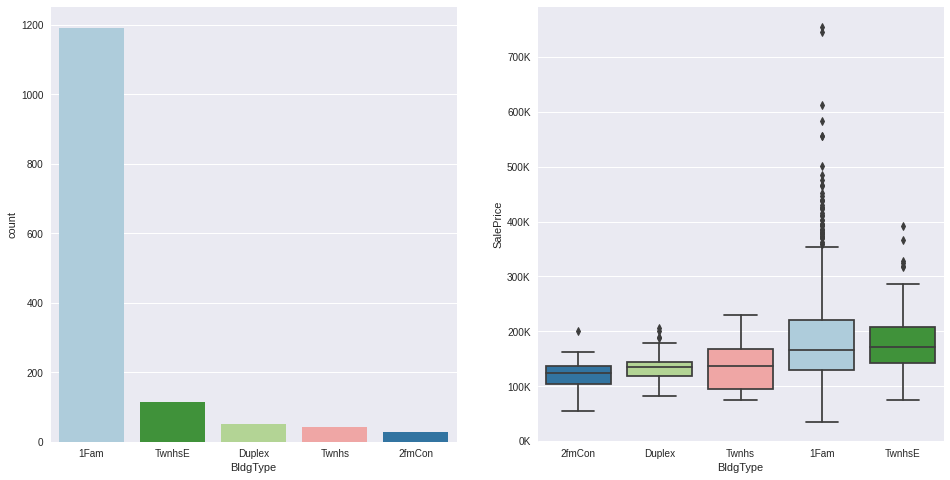

In [ ]:
plot_count_box(data, 'BldgType', 'SalePrice')

Again, high imbalanace and high overlap. A pity as this could be a good feature.

In [ ]:
cols_to_drop += ['BldgType']

HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

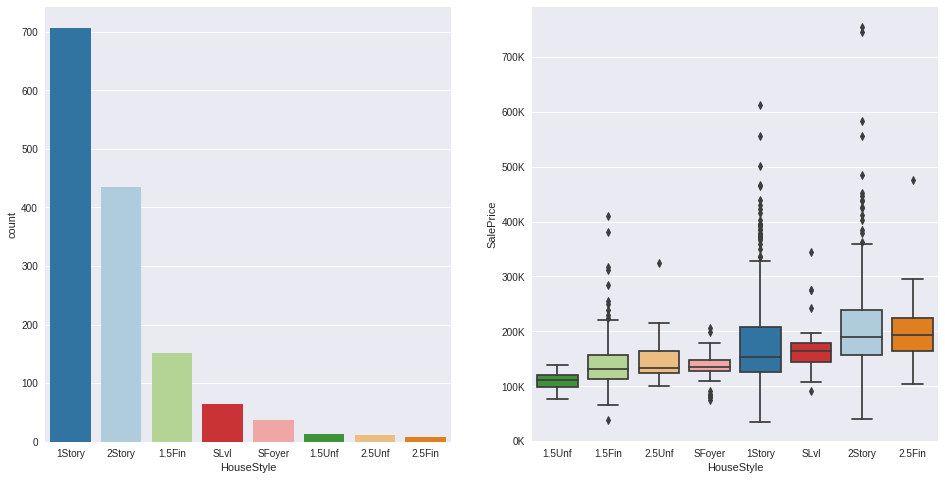

In [ ]:
plot_count_box(data, 'HouseStyle', 'SalePrice')

Same problem

In [ ]:
cols_to_drop += ['HouseStyle']

RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

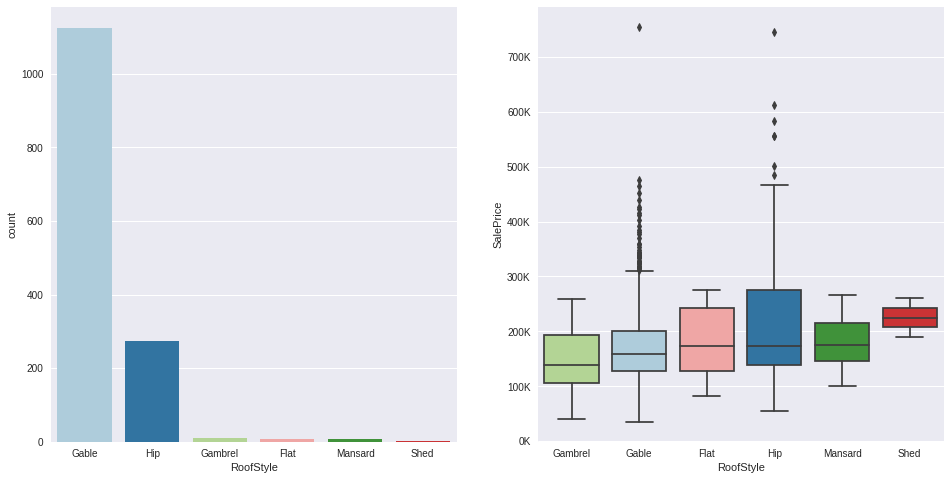

In [ ]:
plot_count_box(data, 'RoofStyle', 'SalePrice')

Same

In [ ]:
cols_to_drop += ['RoofStyle']

RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

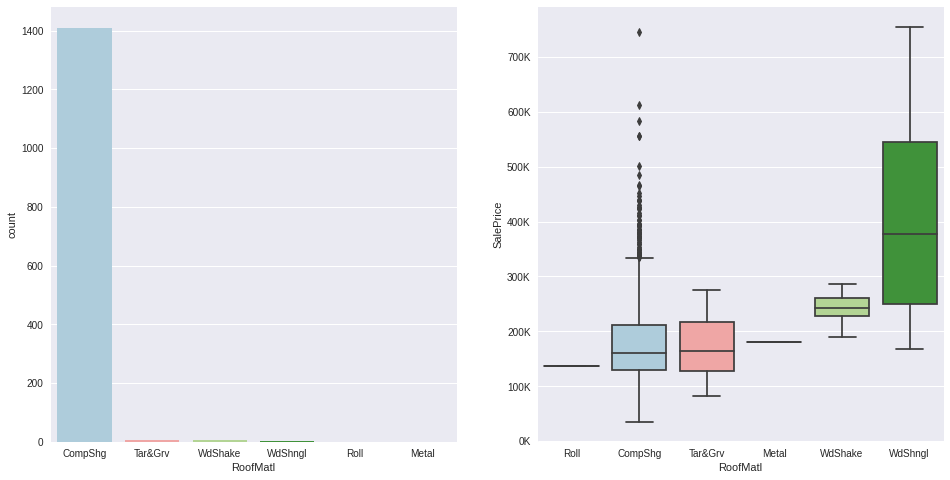

In [ ]:
plot_count_box(data, 'RoofMatl', 'SalePrice')

Apperently WdShngl houses have a higher sale price but the number of samples is nog big enough

In [ ]:
data['RoofMatl'].value_counts()

CompShg    1410
Tar&Grv       7
WdShake       5
WdShngl       4
Roll          1
Metal         1
Name: RoofMatl, dtype: int64

Useless feature because of lack of data

In [ ]:
cols_to_drop += ['RoofMatl']

Exterior1st: Exterior covering on house

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast	
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

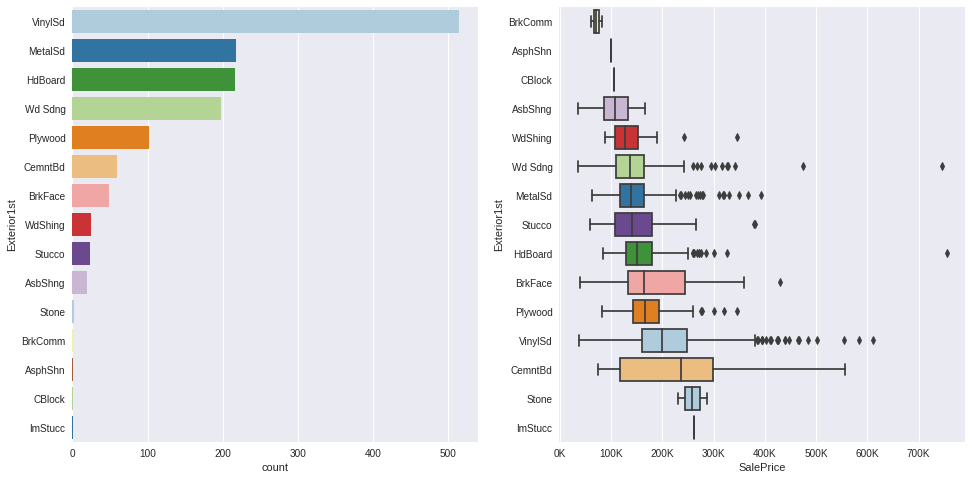

In [ ]:
plot_count_box(data, 'Exterior1st', 'SalePrice', orient = 'h')

We have some values with a lot of samples and others undersampled. We can can think groupping the low sampled groups together.



In [ ]:
data['Exterior1st'].value_counts()

VinylSd    514
MetalSd    217
HdBoard    216
Wd Sdng    197
Plywood    102
CemntBd     59
BrkFace     48
WdShing     25
Stucco      23
AsbShng     20
Stone        2
BrkComm      2
AsphShn      1
CBlock       1
ImStucc      1
Name: Exterior1st, dtype: int64

In [ ]:
data['Exterior1st'] = np.where(data['Exterior1st'].isin(['VinylSd','MetalSd','HdBoard','Wd Sdng','Plywood']),data['Exterior1st'],'Other')

In [ ]:
data['Exterior1st'].value_counts()

VinylSd    514
MetalSd    217
HdBoard    216
Wd Sdng    197
Other      182
Plywood    102
Name: Exterior1st, dtype: int64

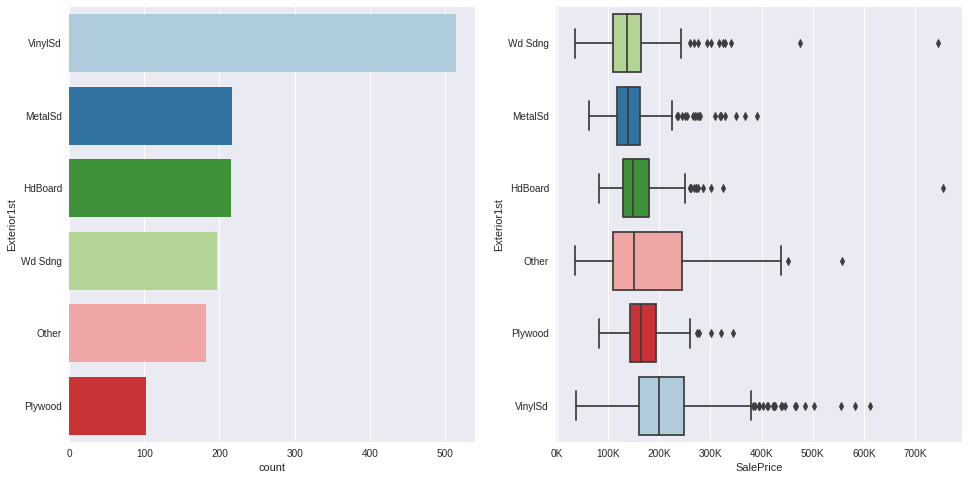

In [ ]:
plot_count_box(data, 'Exterior1st', 'SalePrice', orient = 'h')

Even grouping, this variable doesn't seem to help in determining the final selling prices given the overlap.

In [ ]:
cols_to_drop += ['Exterior1st']

Exterior2nd: Exterior covering on house (if more than one material)

       AsbShng	Asbestos Shingles
       AsphShn	Asphalt Shingles
       BrkComm	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       CemntBd	Cement Board
       HdBoard	Hard Board
       ImStucc	Imitation Stucco
       MetalSd	Metal Siding
       Other	Other
       Plywood	Plywood
       PreCast	PreCast
       Stone	Stone
       Stucco	Stucco
       VinylSd	Vinyl Siding
       Wd Sdng	Wood Siding
       WdShing	Wood Shingles

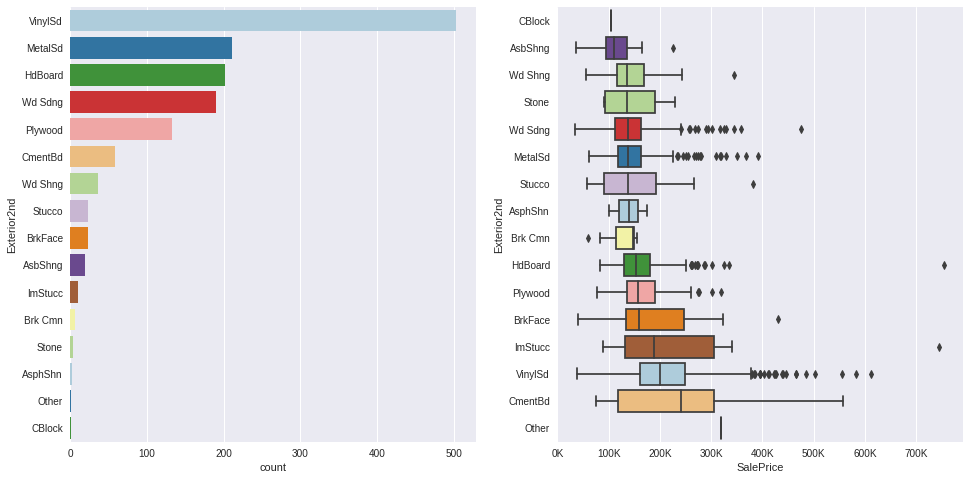

In [ ]:
plot_count_box(data, 'Exterior2nd', 'SalePrice', orient = 'h')

In [ ]:
data['Exterior2nd'].value_counts()

VinylSd    503
MetalSd    211
HdBoard    202
Wd Sdng    190
Plywood    133
CmentBd     59
Wd Shng     36
Stucco      24
BrkFace     24
AsbShng     20
ImStucc     10
Brk Cmn      7
Stone        4
AsphShn      3
Other        1
CBlock       1
Name: Exterior2nd, dtype: int64

It seems to be redundant. Let's drop it.

In [ ]:
cols_to_drop += ['Exterior2nd']

ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

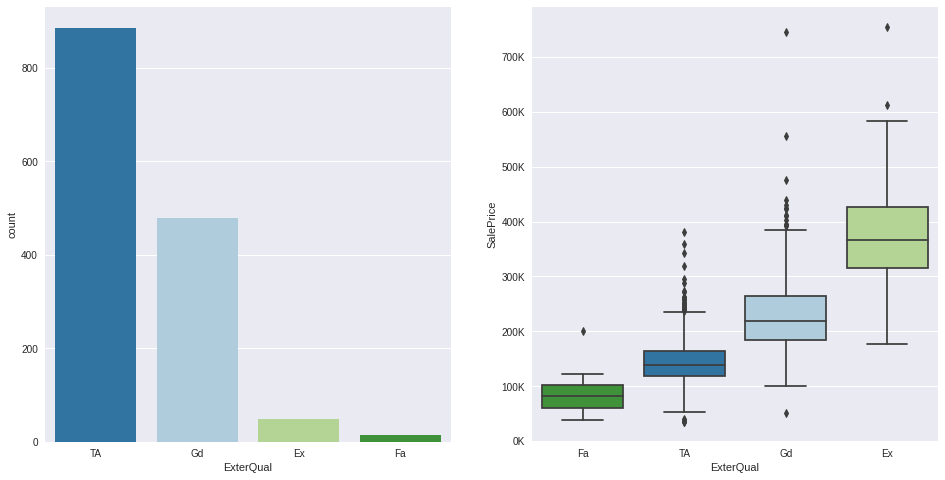

In [ ]:
plot_count_box(data, 'ExterQual', 'SalePrice')

In [ ]:
data['ExterQual'].value_counts()

TA    886
Gd    479
Ex     49
Fa     14
Name: ExterQual, dtype: int64

In [ ]:
m1 = data[data['ExterQual'] == 'Fa']['SalePrice'].mean()
m2 = data[data['ExterQual'].isin(['TA','Gd']) == True]['SalePrice'].mean()
m3 = data[data['ExterQual'] == 'Ex']['SalePrice'].mean()

print("Mean prices of houses with ExterQual = 'Fa': {:.2f}".format(m1))
print("Mean prices of houses with ExterQual = ['TA','Gd']: {:.2f}".format(m2))
print("Mean prices of houses with ExterQual = 'Ex': {:.2f}".format(m3))

print("Ratio m2/m1: {:.2f}".format(m2/m1))
print("Ratio m2/m1: {:.2f}".format(m3/m1))

Mean prices of houses with ExterQual = 'Fa': 87985.21
Mean prices of houses with ExterQual = ['TA','Gd']: 173450.15
Mean prices of houses with ExterQual = 'Ex': 371837.14
Ratio m2/m1: 1.97
Ratio m2/m1: 4.23


In [ ]:
#data['ExterQual'] = np.where(data['ExterQual'].isin(['TA','Gd']),'TA-Gd',data['ExterQual'])
data['ExterQual'] = data['ExterQual'].replace({'Fa':1, 'TA': 1.97,'Gd': 1.97, 'Ex': 4.23})

ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

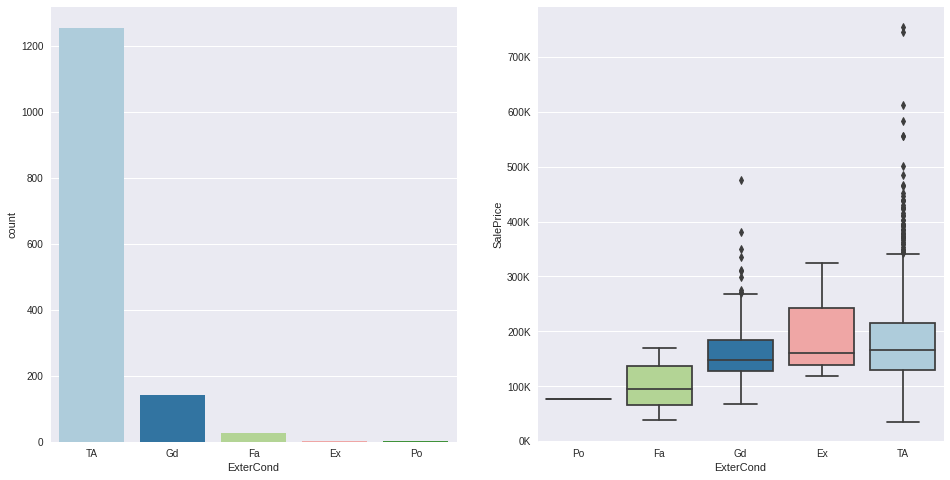

In [ ]:
plot_count_box(data, 'ExterCond', 'SalePrice')

The most sampled value for 'ExterCond' is 'TA' which has a huge range of selling prices. Let's drop it

In [ ]:
cols_to_drop += ['ExterCond']

Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

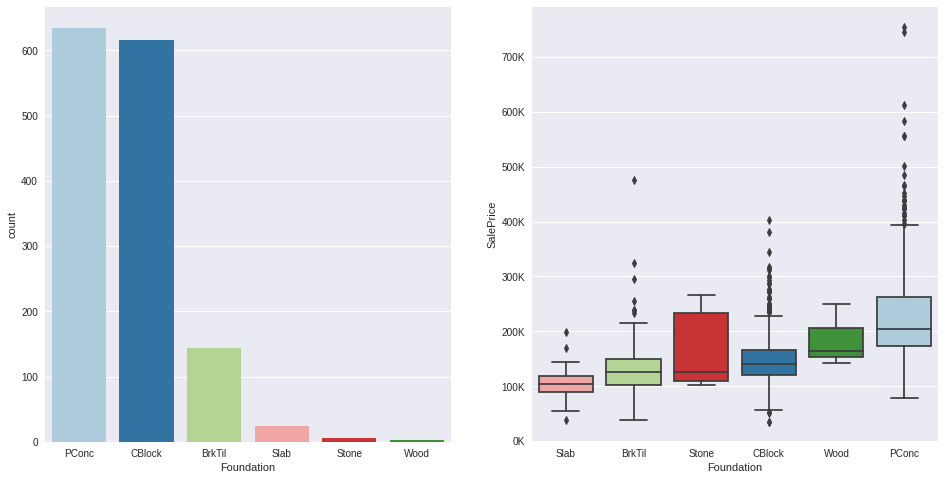

In [ ]:
plot_count_box(data, 'Foundation', 'SalePrice')

No clear conclussions can be extracted

In [ ]:
cols_to_drop += ['Foundation']

Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

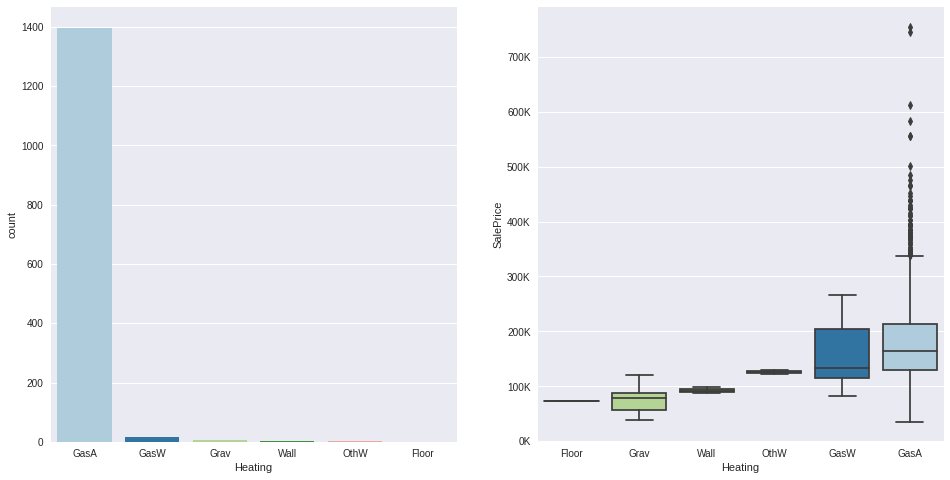

In [ ]:
plot_count_box(data, 'Heating', 'SalePrice')

Not conclussive 

In [ ]:
data['Heating'].value_counts()

GasA     1397
GasW       17
Grav        7
Wall        4
OthW        2
Floor       1
Name: Heating, dtype: int64

In [ ]:
cols_to_drop += ['Heating']

HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

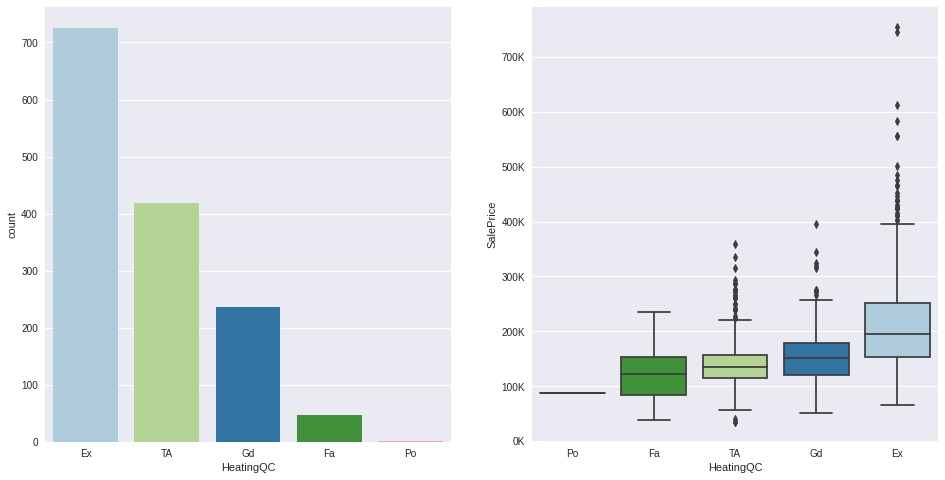

In [ ]:
plot_count_box(data, 'HeatingQC', 'SalePrice')

Good sampling ( except 'poor' ) but high overlap to be conclussive. Let's drop it. 

In [ ]:
cols_to_drop += ['HeatingQC']

CentralAir: Central air conditioning

       N	No
       Y	Yes

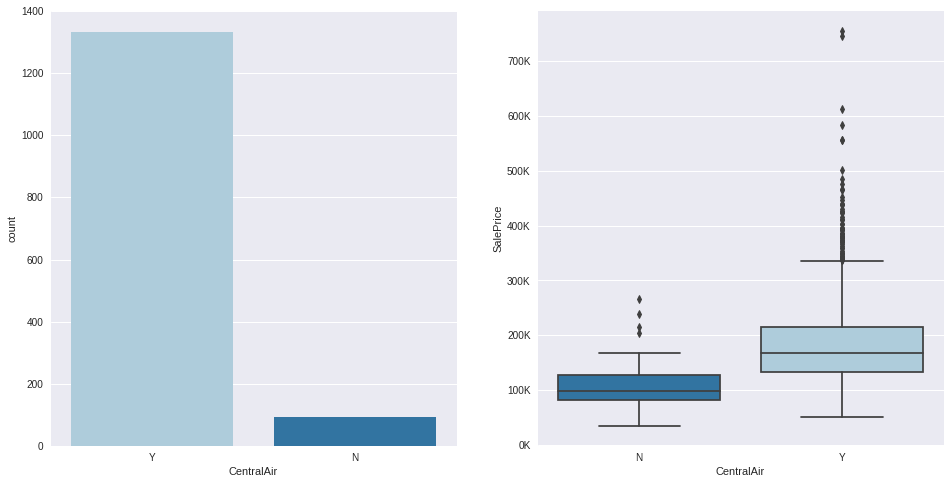

In [ ]:
plot_count_box(data, 'CentralAir', 'SalePrice')

In [ ]:
data['CentralAir'].value_counts()

Y    1334
N      94
Name: CentralAir, dtype: int64

I will keep this feature as even though there is some overlap, in general the selling prices are bigger for houses where CentralAir is present. However, I will recode this feature.

In [ ]:
data['CentralAir'] = np.where(data['CentralAir'] == "Y",1,0)

KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

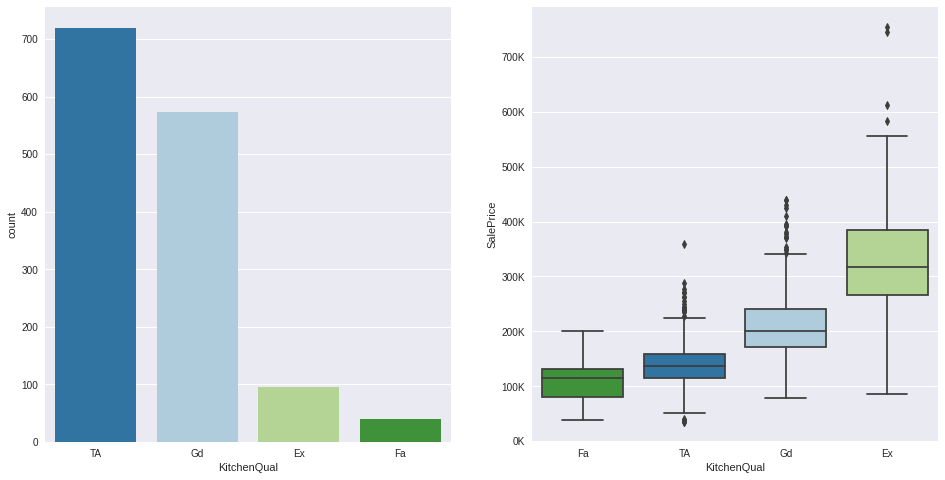

In [ ]:
plot_count_box(data,'KitchenQual', 'SalePrice')

In [ ]:
data['KitchenQual'].value_counts()

TA    720
Gd    573
Ex     96
Fa     39
Name: KitchenQual, dtype: int64

In [ ]:
m1 = data[data['KitchenQual'] == 'Fa']['SalePrice'].mean()
m2 = data[data['KitchenQual'].isin(['TA','Gd']) == True]['SalePrice'].mean()
m3 = data[data['KitchenQual'] == 'Ex']['SalePrice'].mean()

print("Mean price of houses where KitchenQual = 'Fa', {}".format(round(m1,2)))
print("Mean price of houses where KitchenQual = ['TA','Gd'], {}".format(round(m2,2)))
print("Mean price of houses where KitchenQual = 'Ex', {}".format(round(m3,2)))

print("Ratio m2/m1: ",round(m2/m1,2))
print("Ratio m3/m1: ",round(m3/m1,2))

Mean price of houses where KitchenQual = 'Fa', 105565.21
Mean price of houses where KitchenQual = ['TA','Gd'], 170351.52
Mean price of houses where KitchenQual = 'Ex', 331559.55
Ratio m2/m1:  1.61
Ratio m3/m1:  3.14


Sampling is good but the groups can be grouped in two groups:

* Group 1: Ex/Gd
* Group 2: Else

In [ ]:
#data['KitchenQual'] = np.where(data['KitchenQual'].isin(['Fa','Po','TA']),0,1)
data['KitchenQual'] = data['KitchenQual'].replace({'Fa': 1, 'TA': 1.61, 'Gd': 1.61, 'Ex': 3.14})

Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

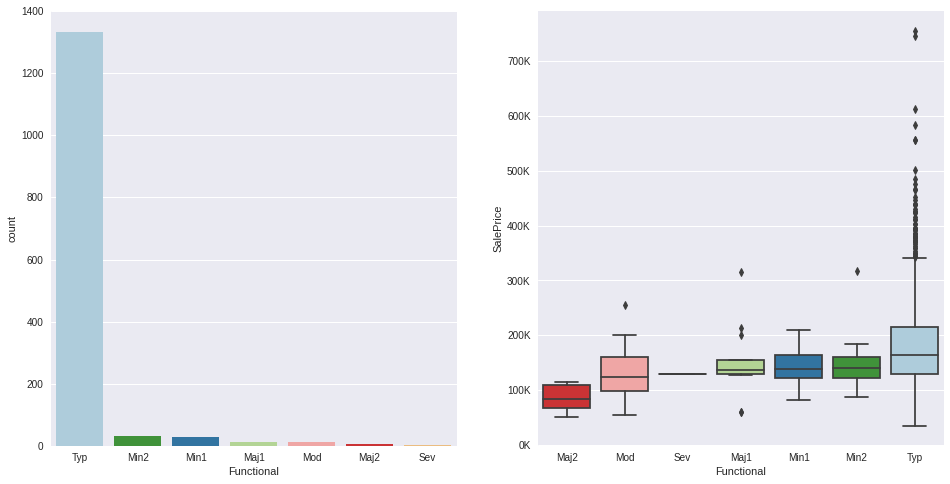

In [ ]:
plot_count_box(data,'Functional', 'SalePrice')

Terrible sampling and high overlap. Feature to drop

In [ ]:
cols_to_drop += ['Functional']

GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

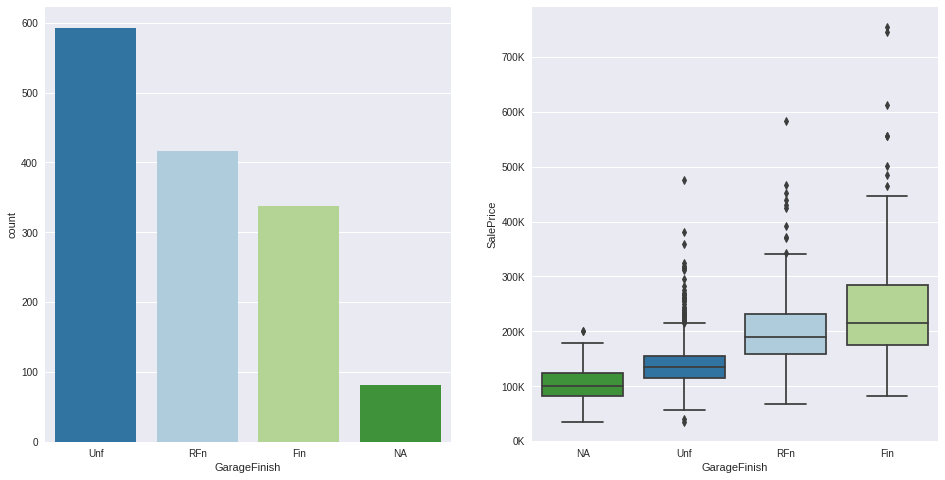

In [ ]:
plot_count_box(data,'GarageFinish', 'SalePrice')

Good sampling but mnot conclussive bercause of overlap. Probably is best to have a feature between having a garage or not. Moreover, there are other numerical features which takes into account the number of cars and the surface. We will drop this feature.

In [ ]:
cols_to_drop += ['GarageFinish']

PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

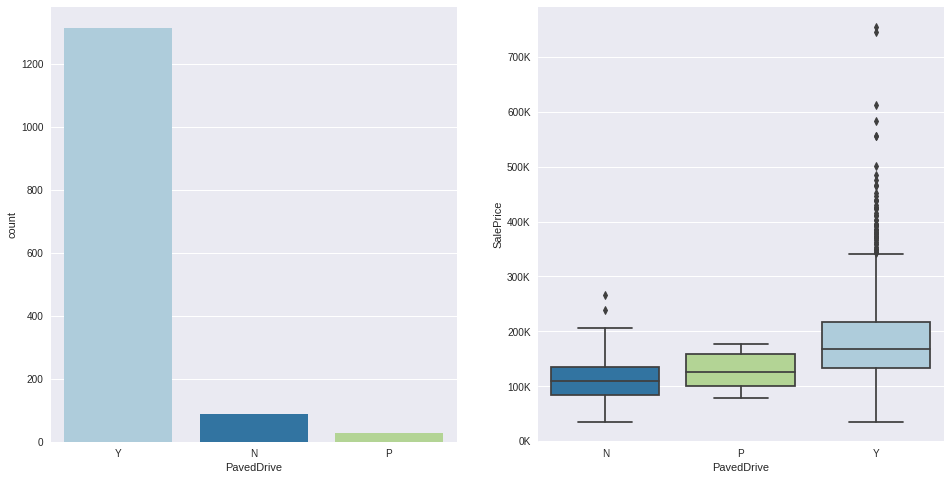

In [ ]:
plot_count_box(data,'PavedDrive', 'SalePrice')

High overlap. Feature to drop.

In [ ]:
cols_to_drop += ['PavedDrive']

SaleType: Type of sale
		
       WD 	Warranty Deed - Conventional
       CWD	Warranty Deed - Cash
       VWD	Warranty Deed - VA Loan
       New	Home just constructed and sold
       COD	Court Officer Deed/Estate
       Con	Contract 15% Down payment regular terms
       ConLw	Contract Low Down payment and low interest
       ConLI	Contract Low Interest
       ConLD	Contract Low Down
       Oth	Other

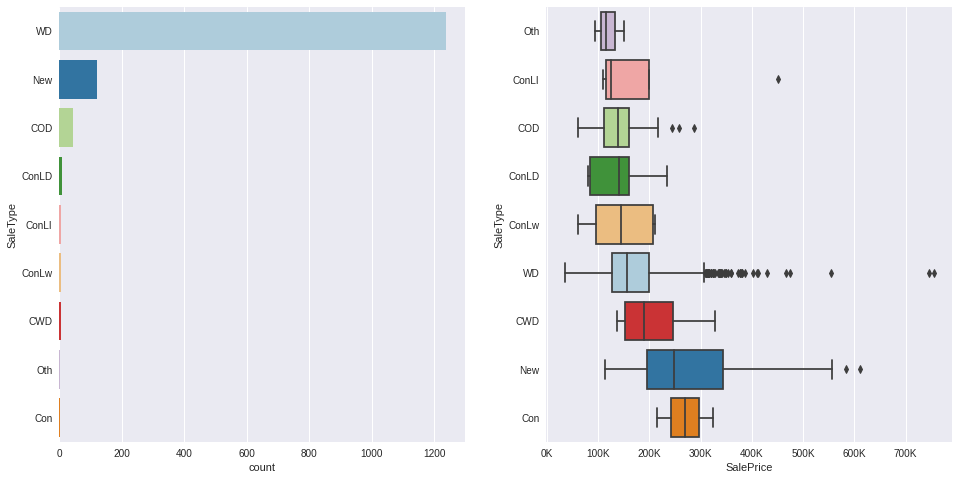

In [ ]:
plot_count_box(data,'SaleType', 'SalePrice', orient = 'h')

In [ ]:
data['SaleType'].value_counts()

WD       1237
New       120
COD        43
ConLD       9
ConLI       5
ConLw       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

Too noisy. Let's drop it.

In [ ]:
cols_to_drop += ['SaleType']

SaleCondition: Condition of sale

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)

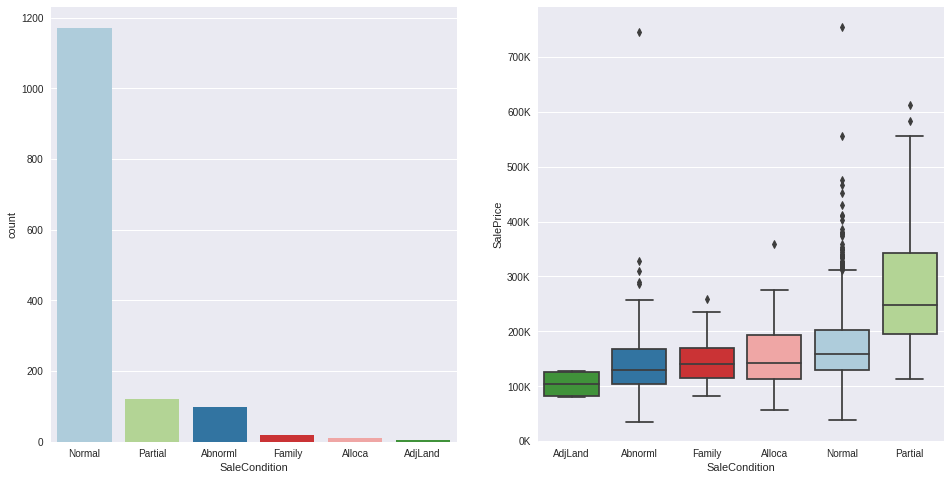

In [ ]:
plot_count_box(data,'SaleCondition', 'SalePrice')

High overlap.

In [ ]:
cols_to_drop += ['SaleCondition']

In [ ]:
cols_to_drop

['Street',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'Condition1',
 'Condition2',
 'BldgType',
 'HouseStyle',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'ExterCond',
 'Foundation',
 'Heating',
 'HeatingQC',
 'Functional',
 'GarageFinish',
 'PavedDrive',
 'SaleType',
 'SaleCondition']

In [ ]:
data.drop(columns=cols_to_drop, axis = 1, inplace = True)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1428 entries, 0 to 1459
Data columns (total 35 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1428 non-null   int64  
 1   MSSubClass     1428 non-null   int64  
 2   LotArea        1428 non-null   int64  
 3   OverallQual    1428 non-null   int64  
 4   YearBuilt      1428 non-null   int64  
 5   YearRemodAdd   1428 non-null   int64  
 6   ExterQual      1428 non-null   float64
 7   BsmtFinSF1     1428 non-null   int64  
 8   TotalBsmtSF    1428 non-null   int64  
 9   CentralAir     1428 non-null   int64  
 10  1stFlrSF       1428 non-null   int64  
 11  2ndFlrSF       1428 non-null   int64  
 12  LowQualFinSF   1428 non-null   int64  
 13  GrLivArea      1428 non-null   int64  
 14  BsmtFullBath   1428 non-null   int64  
 15  BsmtHalfBath   1428 non-null   int64  
 16  FullBath       1428 non-null   int64  
 17  HalfBath       1428 non-null   int64  
 18  BedroomA

# Inspecting numerical columns

In [ ]:
num_cols = data.select_dtypes(np.number)
num_cols.drop(columns='Id', axis = 1, inplace = True)
num_cols.head()

,MSSubClass,LotArea,OverallQual,YearBuilt,YearRemodAdd,ExterQual,BsmtFinSF1,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,Fireplace,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,YrSold,SalePrice
0,60,8450,7,2003,2003,1.97,706,856,1,856,854,0,1710,1,0,2,1,3,1,1.61,8,0,0,2,548,0,61,0,0,0,0,0,2008,208500
1,20,9600,6,1976,1976,1.97,978,1262,1,1262,0,0,1262,0,1,2,0,3,1,1.61,6,1,1,2,460,298,0,0,0,0,0,0,2007,181500
2,60,11250,7,2001,2002,1.97,486,920,1,920,866,0,1786,1,0,2,1,3,1,1.61,6,1,1,2,608,0,42,0,0,0,0,0,2008,223500
3,70,9550,7,1915,1970,1.97,216,756,1,961,756,0,1717,1,0,1,0,3,1,1.61,7,1,1,3,642,0,35,272,0,0,0,0,2006,140000
4,60,14260,8,2000,2000,1.97,655,1145,1,1145,1053,0,2198,1,0,2,1,4,1,1.61,9,1,1,3,836,192,84,0,0,0,0,0,2008,250000


## Dealing with years

In [ ]:
year_cols = [ col for col in num_cols if (col.startswith('Year') or col.startswith('Yr'))]
year_cols

['YearBuilt', 'YearRemodAdd', 'YrSold']

In [ ]:
data[year_cols].head()

,YearBuilt,YearRemodAdd,YrSold
0,2003,2003,2008
1,1976,1976,2007
2,2001,2002,2008
3,1915,1970,2006
4,2000,2000,2008


In [ ]:
data[year_cols].isna().sum()

YearBuilt       0
YearRemodAdd    0
YrSold          0
dtype: int64

In [ ]:
data['YrSold'] - data['YearRemodAdd']

0        5
1       31
2        6
3       36
4        8
        ..
1455     7
1456    22
1457     4
1458    14
1459    43
Length: 1428, dtype: int64

Let's change this columns to datetime

In [ ]:
data['Antiquity'] = data['YrSold'] - data['YearRemodAdd']
data.drop(columns = year_cols, axis = 1, inplace = True)

In [ ]:
num_cols = data.select_dtypes(np.number)
num_cols.drop(columns='Id', axis = 1, inplace = True)
num_cols.head()

,MSSubClass,LotArea,OverallQual,ExterQual,BsmtFinSF1,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,Fireplace,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,Antiquity
0,60,8450,7,1.97,706,856,1,856,854,0,1710,1,0,2,1,3,1,1.61,8,0,0,2,548,0,61,0,0,0,0,0,208500,5
1,20,9600,6,1.97,978,1262,1,1262,0,0,1262,0,1,2,0,3,1,1.61,6,1,1,2,460,298,0,0,0,0,0,0,181500,31
2,60,11250,7,1.97,486,920,1,920,866,0,1786,1,0,2,1,3,1,1.61,6,1,1,2,608,0,42,0,0,0,0,0,223500,6
3,70,9550,7,1.97,216,756,1,961,756,0,1717,1,0,1,0,3,1,1.61,7,1,1,3,642,0,35,272,0,0,0,0,140000,36
4,60,14260,8,1.97,655,1145,1,1145,1053,0,2198,1,0,2,1,4,1,1.61,9,1,1,3,836,192,84,0,0,0,0,0,250000,8


In [ ]:
abs(num_cols.corr())

,MSSubClass,LotArea,OverallQual,ExterQual,BsmtFinSF1,TotalBsmtSF,CentralAir,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Fireplaces,Fireplace,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,SalePrice,Antiquity
MSSubClass,1.00,0.40,0.04,0.04,0.08,0.26,0.09,0.26,0.31,0.05,0.08,0.00,0.00,0.14,0.18,0.03,0.29,0.04,0.04,0.04,0.03,0.05,0.11,0.03,0.00,0.01,0.04,0.02,0.00,0.01,0.08,0.05
LotArea,0.40,1.00,0.22,0.14,0.17,0.32,0.09,0.42,0.13,0.02,0.42,0.08,0.03,0.20,0.11,0.28,0.03,0.18,0.39,0.33,0.30,0.29,0.33,0.16,0.16,0.01,0.09,0.10,0.08,0.06,0.42,0.06
OverallQual,0.04,0.22,1.00,0.40,0.22,0.54,0.27,0.48,0.28,0.04,0.59,0.10,0.04,0.56,0.27,0.10,0.19,0.46,0.42,0.40,0.44,0.61,0.57,0.24,0.30,0.13,0.03,0.07,0.03,0.03,0.80,0.55
ExterQual,0.04,0.14,0.40,1.00,0.19,0.33,0.10,0.31,0.02,0.05,0.24,0.08,0.01,0.19,0.06,0.01,0.06,0.54,0.22,0.18,0.18,0.26,0.27,0.11,0.17,0.08,0.04,0.05,0.01,0.00,0.48,0.22
BsmtFinSF1,0.08,0.17,0.22,0.19,1.00,0.46,0.18,0.38,0.18,0.08,0.12,0.65,0.07,0.05,0.01,0.12,0.08,0.24,0.00,0.23,0.17,0.22,0.26,0.18,0.07,0.11,0.03,0.07,0.05,0.00,0.39,0.13
TotalBsmtSF,0.26,0.32,0.54,0.33,0.46,1.00,0.22,0.81,0.22,0.04,0.40,0.28,0.00,0.33,0.07,0.05,0.08,0.36,0.27,0.32,0.31,0.45,0.47,0.23,0.21,0.10,0.04,0.09,0.03,0.02,0.65,0.30
CentralAir,0.09,0.09,0.27,0.10,0.18,0.22,1.00,0.15,0.02,0.05,0.09,0.12,0.04,0.11,0.14,0.01,0.25,0.13,0.03,0.18,0.20,0.24,0.23,0.15,0.02,0.16,0.03,0.05,0.02,0.00,0.25,0.30
1stFlrSF,0.26,0.42,0.48,0.31,0.38,0.81,0.15,1.00,0.24,0.01,0.53,0.21,0.00,0.38,0.13,0.13,0.06,0.35,0.40,0.39,0.37,0.45,0.48,0.23,0.18,0.07,0.06,0.10,0.06,0.02,0.63,0.25
2ndFlrSF,0.31,0.13,0.28,0.02,0.18,0.22,0.02,0.24,1.00,0.05,0.69,0.18,0.04,0.41,0.61,0.50,0.07,0.05,0.61,0.20,0.21,0.18,0.13,0.08,0.20,0.06,0.02,0.03,0.06,0.02,0.31,0.13
LowQualFinSF,0.05,0.02,0.04,0.05,0.08,0.04,0.05,0.01,0.05,1.00,0.13,0.05,0.03,0.00,0.02,0.10,0.01,0.01,0.13,0.02,0.04,0.10,0.08,0.02,0.02,0.01,0.00,0.03,0.01,0.00,0.03,0.06


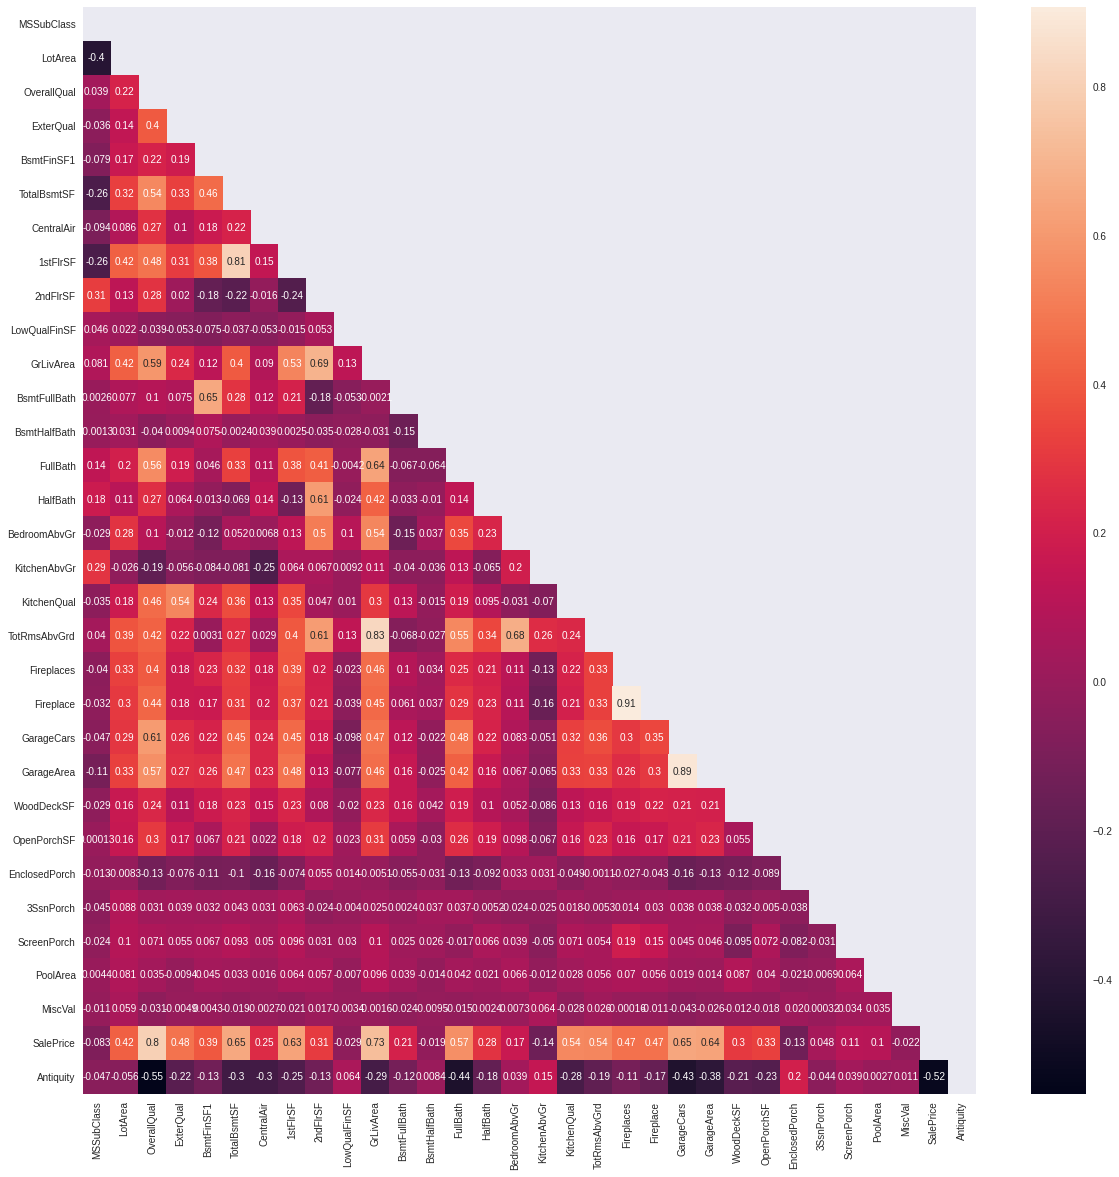

In [ ]:
c = num_cols.corr()
fig_dims = (20, 20)
mask = np.triu(np.ones_like(c, dtype=bool))
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(c, annot=True,ax = ax, mask=mask)

## Filtering features based on the correlation matrix

As we are going to use a **linear model** to predict the sale price, we can use the correlation matrix which quantifies the **linear realtionship** ( it can be other types of relationships not covered by a linear model ) to discard features. 

We will do this in two steps: 

First, we wil discard all those features for which the absolute value between the feature and the **SalePrice** is smaller than 0.5 ( usually I chose 0.75, however not too much features have such a high correlation, therefore we are in the risk of ending with a very reduced set of features). 

Second, we will dicard those fetature which are highly correlated among themselves as they are providing the same amount of information.

In [ ]:
d = pd.DataFrame(np.abs(c.loc[:,'SalePrice']).sort_values(ascending=False)).reset_index()
d.columns = ['Column','SalePrice']
d

,Column,SalePrice
0,SalePrice,1.00
1,OverallQual,0.80
2,GrLivArea,0.73
3,TotalBsmtSF,0.65
4,GarageCars,0.65
5,GarageArea,0.64
6,1stFlrSF,0.63
7,FullBath,0.57
8,KitchenQual,0.54
9,TotRmsAbvGrd,0.54


Let's create a new list of columns to drop.

In [ ]:
cols_to_drop = []
d[d['SalePrice'] < 0.5]['Column'].tolist()

['ExterQual',
 'Fireplace',
 'Fireplaces',
 'LotArea',
 'BsmtFinSF1',
 'OpenPorchSF',
 '2ndFlrSF',
 'WoodDeckSF',
 'HalfBath',
 'CentralAir',
 'BsmtFullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea',
 'MSSubClass',
 '3SsnPorch',
 'LowQualFinSF',
 'MiscVal',
 'BsmtHalfBath']

In [ ]:
cols_to_drop += d[d['SalePrice'] < 0.5]['Column'].tolist()
cols_to_drop

['ExterQual',
 'Fireplace',
 'Fireplaces',
 'LotArea',
 'BsmtFinSF1',
 'OpenPorchSF',
 '2ndFlrSF',
 'WoodDeckSF',
 'HalfBath',
 'CentralAir',
 'BsmtFullBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'EnclosedPorch',
 'ScreenPorch',
 'PoolArea',
 'MSSubClass',
 '3SsnPorch',
 'LowQualFinSF',
 'MiscVal',
 'BsmtHalfBath']

In [ ]:
data.drop(columns=cols_to_drop, axis = 1, inplace = True)

In [ ]:
num_cols = data.select_dtypes(np.number)
num_cols.drop(columns='Id', axis = 1, inplace = True)
num_cols.head()

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,SalePrice,Antiquity
0,7,856,856,1710,2,1.61,8,2,548,208500,5
1,6,1262,1262,1262,2,1.61,6,2,460,181500,31
2,7,920,920,1786,2,1.61,6,2,608,223500,6
3,7,756,961,1717,1,1.61,7,3,642,140000,36
4,8,1145,1145,2198,2,1.61,9,3,836,250000,8


Place column SalePrice to the end

In [ ]:
num_cols = num_cols[[ col for col in num_cols.columns if col != 'SalePrice'] + ['SalePrice']]
num_cols

,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,Antiquity,SalePrice
0,7,856,856,1710,2,1.61,8,2,548,5,208500
1,6,1262,1262,1262,2,1.61,6,2,460,31,181500
2,7,920,920,1786,2,1.61,6,2,608,6,223500
3,7,756,961,1717,1,1.61,7,3,642,36,140000
4,8,1145,1145,2198,2,1.61,9,3,836,8,250000
...,...,...,...,...,...,...,...,...,...,...,...
1455,6,953,953,1647,2,1.61,7,2,460,7,175000
1456,6,1542,2073,2073,2,1.61,7,2,500,22,210000
1457,7,1152,1188,2340,2,1.61,9,1,252,4,266500
1458,5,1078,1078,1078,1,1.61,5,1,240,14,142125


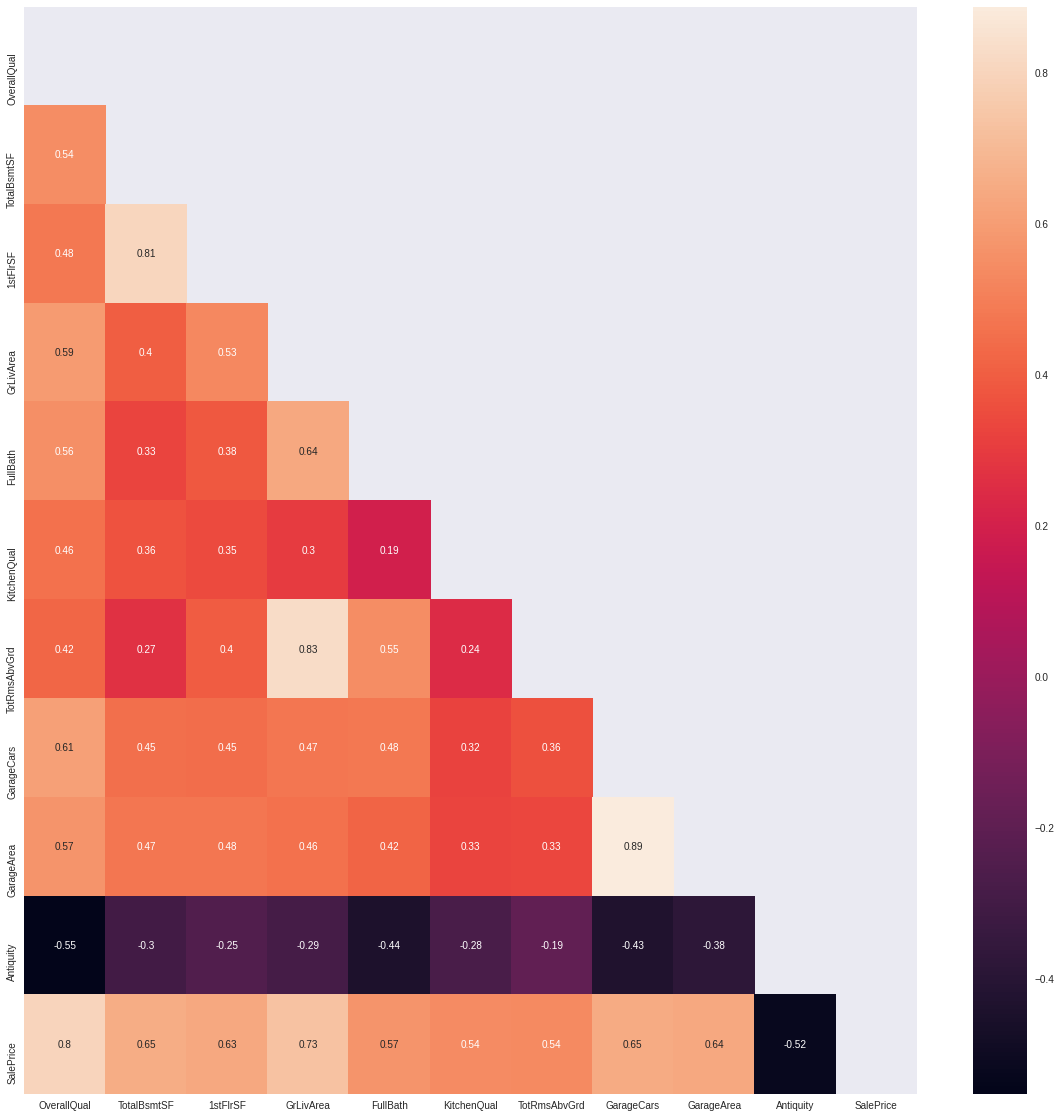

In [ ]:
c = num_cols.corr()
fig_dims = (20, 20)
mask = np.triu(np.ones_like(c, dtype=bool))
fig, ax = plt.subplots(figsize=fig_dims)
sns.heatmap(c, annot=True,ax = ax, mask=mask)

Droping redundant columns: ie. columns highly correlated among themselves ( coor > 0.75). From those pairs, we will drop the ones which are **less correlated** with the dependent variable.

corr(`1stFlrSF`,`TotalBsmtSF`) > 0.75 and 
corr(`1stFlrSF`,`SalePrice`) = 0.63 <  corr(`TotalBsmtSF``,`SalePrice`)

we will drop `1stFlrSF`

corr(`TotRmsAbvGrd`,`GrLivArea`) > 0.75 and 
corr(`TotRmsAbvGrd`,`SalePrice`) = 0.54 <  corr(`GrLivArea`,`SalePrice`)

therefore, we will drop `TotRmsAbvGrd`

corr(`GarageArea`,`GarageCars`) > 0.75 and 
corr(`GarageArea`,`SalePrice`) = 0.64 <  corr(`GarageCars`,`SalePrice`)

therefore, we will drop `GarageArea`

In [ ]:
#cols_to_drop = ['1stFlrSF','TotRmsAbvGrd','GarageArea']
#data.drop(columns=cols_to_drop,axis=1,inplace = True)
data = data[[ col for col in data.columns if col != 'SalePrice'] + ['SalePrice']]
data.head()

,Id,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,Antiquity,SalePrice
0,1,7,856,856,1710,2,1.61,8,2,548,5,208500
1,2,6,1262,1262,1262,2,1.61,6,2,460,31,181500
2,3,7,920,920,1786,2,1.61,6,2,608,6,223500
3,4,7,756,961,1717,1,1.61,7,3,642,36,140000
4,5,8,1145,1145,2198,2,1.61,9,3,836,8,250000


In [ ]:
data.columns.tolist()

['Id',
 'OverallQual',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'TotRmsAbvGrd',
 'GarageCars',
 'GarageArea',
 'Antiquity',
 'SalePrice']

# Saving changes

In [ ]:
data.to_csv('/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/transformed_data.csv',index=False)

# Modelling

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import pickle

trans = PowerTransformer()
model = LinearRegression()

# define X and y (features and target)
X = data.drop(columns = ['Id','SalePrice'])
y = np.log(data['SalePrice']) # The model will try to predict the log(SalePrice) instead of the real price

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

# transforming data
trans.fit(X_train)

# Saving the transformer
with open('/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/transformer.pkl', 'wb')  as f:
    pickle.dump(trans,f)

X_train = trans.transform(X_train)
X_test  = trans.transform(X_test)

X_train = pd.DataFrame(X_train, columns = X.columns)
X_test  = pd.DataFrame(X_test,  columns = X.columns)

X_train.to_csv('/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/X_train.csv')
X_test.to_csv('/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/X_test.csv')

# model
model.fit(X_train, y_train)

with open('/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/model.pkl', 'wb')  as f:
    pickle.dump(model,f)

y_pred_train = model.predict(X_train)
y_pred_test  = model.predict(X_test)


In [ ]:
# Model validation
def model_performance(y_train, y_pred_train, y_test, y_pred_test):

    ME_train = np.mean(np.exp(y_train)-np.exp(y_pred_train))
    ME_test  = np.mean(np.exp(y_test)-np.exp(y_pred_test))

    MAE_train = mean_absolute_error(np.exp(y_train),np.exp(y_pred_train))
    MAE_test  = mean_absolute_error(np.exp(y_test),np.exp(y_pred_test))

    MSE_train = mean_squared_error(np.exp(y_train),np.exp(y_pred_train))
    MSE_test  = mean_squared_error(np.exp(y_test),np.exp(y_pred_test))

    RMSE_train = np.sqrt(MSE_train)
    RMSE_test  = np.sqrt(MSE_test)

    MAPE_train = np.mean((np.abs(np.exp(y_train)-np.exp(y_pred_train)) / np.exp(y_train))* 100.)
    MAPE_test  = np.mean((np.abs(np.exp(y_test)-np.exp(y_pred_test)) / np.exp(y_test))* 100.)

    R2_train = r2_score(np.exp(y_train),np.exp(y_pred_train))
    R2_test  = r2_score(np.exp(y_test),np.exp(y_pred_test))

    performance = pd.DataFrame({'Error_metric': ['Mean error','Mean absolute error','Mean squared error',
                                             'Root mean squared error','Mean absolute percentual error',
                                             'R2'],
                            'Train': [ME_train, MAE_train, MSE_train, RMSE_train, MAPE_train, R2_train],
                            'Test' : [ME_test, MAE_test , MSE_test, RMSE_test, MAPE_test, R2_test]})

    pd.options.display.float_format = '{:.2f}'.format

    df_train = pd.DataFrame({'x': np.exp(y_train), 'y': np.exp(y_pred_train)})
    df_test  = pd.DataFrame({'x': np.exp(y_test),  'y': np.exp(y_pred_test)})

    return performance, df_train, df_test

In [ ]:
performance,_,_ = model_performance(y_train, y_pred_train, y_test, y_pred_test)
performance

,Error_metric,Train,Test
0,Mean error,2058.11,1529.57
1,Mean absolute error,19164.78,19229.13
2,Mean squared error,773371417.14,742993182.86
3,Root mean squared error,27809.56,27257.90
4,Mean absolute percentual error,11.51,11.82
5,R2,0.87,0.88


In [ ]:
def show_errors(y_real_train, y_pred_train, y_real_test, y_pred_test):

    plt.style.use('seaborn') 

    fig, ax = plt.subplots(2,2,figsize=(10,10))
    
    ax[0,0].scatter(x = np.exp(y_real_train), y = np.exp(y_pred_train), c = 'green')
    ax[0,0].plot([0,700000], [0,700000], linestyle = '--',c = 'black')
    ax[0,0].set_xlim(0,700000)
    ax[0,0].set_ylim(0,700000)

    ax[0,0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    ax[0,0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    ax[0,0].set_title('Train set')

    ax[0,1].hist(x = np.exp(y_real_train)-np.exp(y_pred_train), bins = 50,color = 'green')
    ax[0,1].set_xlim(-200000,200000)
    ax[0,1].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    ax[0,1].set_title('Train set')

    ax[1,0].scatter(x = np.exp(y_real_test), y = np.exp(y_pred_test), c = 'blue')
    ax[1,0].plot([0,700000], [0,700000], linestyle = '--',c = 'black')
    ax[1,0].set_xlim(0,700000)
    ax[1,0].set_ylim(0,700000)
    ax[1,0].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    ax[1,0].yaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    ax[1,0].set_title('Test set')   

    ax[1,1].hist(x = np.exp(y_real_test)-np.exp(y_pred_test), bins = 50,color = 'blue')
    ax[1,1].set_xlim(-200000,200000)
    ax[1,1].xaxis.set_major_formatter(FuncFormatter(lambda x, p: f'{int(x/1000)}K'))
    ax[1,1].set_title('Test set')

    fig.tight_layout()
    pass

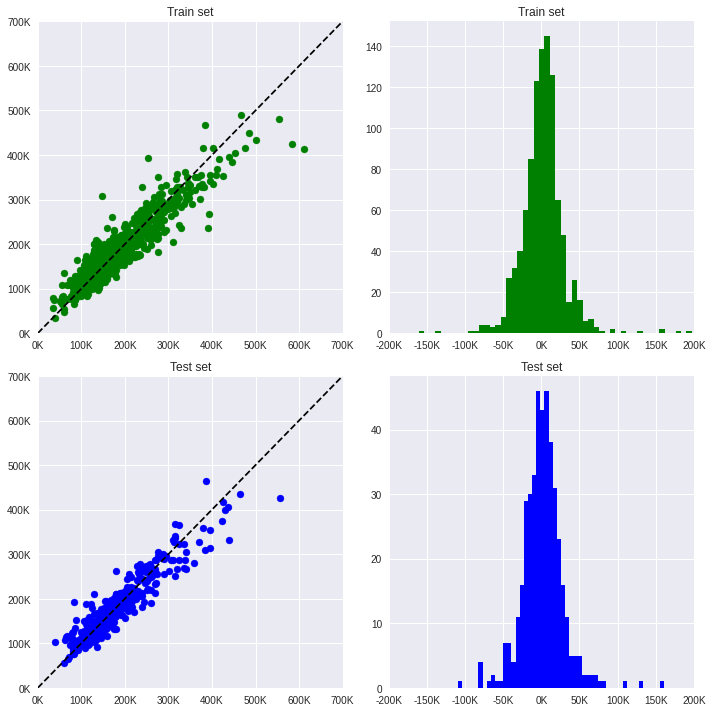

In [ ]:
show_errors(y_train, y_pred_train, y_test, y_pred_test)

# Recaping all the transformations

In [ ]:
'''
data['Antiquity'] = data['YrSold'] - data['YearRemodAdd']
data[data['LotArea'] < 25000 ]
cols_to_keep = ['Id',
 'OverallQual',
 'TotalBsmtSF',
 'GrLivArea',
 'FullBath',
 'KitchenQual',
 'GarageCars',
 'Antiquity',
 'SalePrice',]
data['KitchenQual'] = data['KitchenQual'].replace({'Fa': 1, 'TA': 1.61, 'Gd': 1.61 'Ex': 3.14}, inplace = True)
data = data[[ col for col in data.columns if col != 'SalePrice'] + ['SalePrice']]
'''

"\ndata['Antiquity'] = data['YrSold'] - data['YearRemodAdd']\ndata[data['LotArea'] < 25000 ]\ncols_to_keep = ['Id',\n 'OverallQual',\n 'TotalBsmtSF',\n 'GrLivArea',\n 'FullBath',\n 'KitchenQual',\n 'GarageCars',\n 'Antiquity',\n 'SalePrice',]\ndata['KitchenQual'] = data['KitchenQual'].replace({'Fa': 1, 'TA': 1.61, 'Gd': 1.61 'Ex': 3.14}, inplace = True)\ndata = data[[ col for col in data.columns if col != 'SalePrice'] + ['SalePrice']]\n"

## Create a preprocess function

In [ ]:
def preprocessing(df):
    '''
    Function to trasnform an input dataframe.
    It will add another column named "Antiquity"
    Drop all the Year related columns
    Drop any column not in
    cols_to_keep = ['Id',
   'OverallQual',
   'TotalBsmtSF',
   'GrLivArea',
   'FullBath',
   'KitchenQual',
   'GarageCars',
   'Antiquity',
   'SalePrice']
    Replace values of variable KitchenQual to
    {'Fa': 1, 'TA': 1.61, 'Gd': 1.61, 'Ex': 3.14}
    Drop any row with 'LotArea' < 25000   
    Input: 
    df = Pandas DataFrame object
    Output:
    Transformed DataFrame
    '''
    df2 = df.copy()

    # Computing Antiquity
    df2['Antiquity'] = df2['YrSold'] - df2['YearRemodAdd']
    year_cols = ['YearBuilt', 'YearRemodAdd', 'YrSold']
    df2.drop(columns = year_cols, axis = 1, inplace = True)

    # Filtering by LotArea
    df2 = df2[df2['LotArea'] < 25000 ]

    # Droping unwanted columns
    cols_to_keep = ['Id',
   'OverallQual',
   'TotalBsmtSF',
   'GrLivArea',
   'FullBath',
   'KitchenQual',
   'GarageCars',
   'Antiquity',
   'SalePrice']
    df2 = df2[cols_to_keep]

    # Replacing KitchenQual values by numerical ones.
    df2['KitchenQual'] = df2['KitchenQual'].replace({'Fa': 1, 'TA': 1.61, 'Gd': 1.61, 'Ex': 3.14})

    return df2

## Apply the preprocess function

In [ ]:
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_transformer

data2 = pd.read_csv("/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/housing_prices.csv") 

data2 = preprocessing(data2)

data2.head()


,Id,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,Antiquity,SalePrice
0,1,7,856,856,1710,2,1.61,8,2,548,5,208500
1,2,6,1262,1262,1262,2,1.61,6,2,460,31,181500
2,3,7,920,920,1786,2,1.61,6,2,608,6,223500
3,4,7,756,961,1717,1,1.61,7,3,642,36,140000
4,5,8,1145,1145,2198,2,1.61,9,3,836,8,250000


In [ ]:
data2 == data

,Id,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,Antiquity,SalePrice
0,True,True,True,True,True,True,True,True,True,True,True,True
1,True,True,True,True,True,True,True,True,True,True,True,True
2,True,True,True,True,True,True,True,True,True,True,True,True
3,True,True,True,True,True,True,True,True,True,True,True,True
4,True,True,True,True,True,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,True,True,True,True,True,True,True,True,True,True,True,True
1456,True,True,True,True,True,True,True,True,True,True,True,True
1457,True,True,True,True,True,True,True,True,True,True,True,True
1458,True,True,True,True,True,True,True,True,True,True,True,True


# Inspecting the model

## Getting the coeficients

In [ ]:
model.coef_

array([ 0.12744565,  0.05942581,  0.02263646,  0.13711771,  0.01000333,
        0.02459918, -0.02836918,  0.02222223,  0.0462867 , -0.05260595])

In [ ]:
coeficients = pd.DataFrame({'Column': list(X_train.columns), 'Coef': list(model.coef_)}).sort_values(by ='Coef', ascending= False)
coeficients

,Column,Coef
3,GrLivArea,0.14
0,OverallQual,0.13
1,TotalBsmtSF,0.06
8,GarageArea,0.05
5,KitchenQual,0.02
2,1stFlrSF,0.02
7,GarageCars,0.02
4,FullBath,0.01
6,TotRmsAbvGrd,-0.03
9,Antiquity,-0.05


## Getting the slope

In [ ]:
model.intercept_

12.013650565637276

In fact, we can't interpret this as starting price as this is the model predicts the logarithm. Therefore, this is the logarithm of the starting price. 

In [ ]:
round(np.exp(model.intercept_),2)

164991.72

# Creating your own transformer

You can create a transformer of your choice using your own function. Then you will have access to the methods:

* fit
* transform
* fit_transform
* inv_transform

In [ ]:
data3 = pd.read_csv("/content/drive/MyDrive/OLD_CURR/UNIT7/DAY1/housing_prices.csv") 

In [ ]:
from sklearn.preprocessing import FunctionTransformer

procTransformer = FunctionTransformer(preprocessing)

X_new = procTransformer.transform(data3)
X_new

,Id,OverallQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,KitchenQual,TotRmsAbvGrd,GarageCars,GarageArea,Antiquity,SalePrice
0,1,7,856,856,1710,2,1.61,8,2,548,5,208500
1,2,6,1262,1262,1262,2,1.61,6,2,460,31,181500
2,3,7,920,920,1786,2,1.61,6,2,608,6,223500
3,4,7,756,961,1717,1,1.61,7,3,642,36,140000
4,5,8,1145,1145,2198,2,1.61,9,3,836,8,250000
...,...,...,...,...,...,...,...,...,...,...,...,...
1455,1456,6,953,953,1647,2,1.61,7,2,460,7,175000
1456,1457,6,1542,2073,2073,2,1.61,7,2,500,22,210000
1457,1458,7,1152,1188,2340,2,1.61,9,1,252,4,266500
1458,1459,5,1078,1078,1078,1,1.61,5,1,240,14,142125


In [ ]:
type(X_new)

pandas.core.frame.DataFrame